# Ultimate 25k+ Matches Football Database Data Analysis - Part 2: Exploratory Data Analysis, Statistical Inference and Applying Linear Models

## Objectives:
- perform EDA and visualize data;
- raise and check hypotheses;
- practice statistical inference;
- apply linear machine learning models;
- provide suggestions to the business executives to improve betting on soccer.

## Research questions:
- Which leagues are in which countries? Which teams are in which league?
- Which leagues score the most/fewest goals (in total/home/away)?
- How do team attributes compare between the top/bottom-3 leagues (by goals per match ratio)?
- What teams are the top scorers in each league and overall(by # of goals per match)?
- What are the top and bottom teams by win percentage (total/home/away)?
- What are the top and bottom players in each league and overall (by overall rating)?
- How does win percentage correlate with goals per game ratio? How do mean player ratings correlate with win percentage for teams?
- How do team attributes compare between the top/bottom teams (by win percentage)?

## Hypotheses:
- There is a home advantage: teams tend to play better at home.
- Team attributes are different for best and worst winning teams.
- Overall mean player attributes are higher for best winning teams.

## Biases:
- Not all teams played for all five seasons.
- Overall player score was taken from the original dataset. We are not sure how those ratings were calculated. 

## Additional notes:
- We are focusing on analyzing data for the last 5 seasons in the dataset (2011-2016)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [313]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import textwrap
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import mannwhitneyu

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


from sklearn.feature_selection import RFECV


import helper_functions as hf

import sqlite3 as sql

sns.set_style("darkgrid")
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
# connect to the database
conn = sql.connect("database.sqlite")

# create a cursor
c = conn.cursor()

<IPython.core.display.Javascript object>

In [4]:
match_info = pd.read_sql(
    """
            SELECT *
            FROM match_info;
            """,
    conn,
)
match_info

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,H_bet_prob,D_bet_prob,A_bet_prob,league_name,country_name
0,1,1,2011/2012,1,2011-07-29 00:00:00,1032692,1773,8635,2,1,...,114333.0,178249.0,265123.0,46552.0,181276.0,0.165000,0.260000,0.670000,Belgium Jupiler League,Belgium
1,1,1,2011/2012,1,2011-07-30 00:00:00,1032693,9998,9985,1,1,...,17276.0,119117.0,38382.0,248689.0,46335.0,0.221667,0.290000,0.586667,Belgium Jupiler League,Belgium
2,1,1,2011/2012,1,2011-07-30 00:00:00,1032694,9987,9993,3,1,...,163613.0,38371.0,33622.0,166679.0,14487.0,0.690000,0.245000,0.158333,Belgium Jupiler League,Belgium
3,1,1,2011/2012,1,2011-07-30 00:00:00,1032697,8571,9989,1,1,...,192323.0,32760.0,181073.0,27423.0,33098.0,0.568333,0.290000,0.241667,Belgium Jupiler League,Belgium
4,1,1,2011/2012,1,2011-07-30 00:00:00,1032698,8203,9997,2,1,...,37972.0,37866.0,68120.0,104415.0,68226.0,0.603333,0.281667,0.213333,Belgium Jupiler League,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13063,21518,21518,2015/2016,9,2015-10-25 00:00:00,2030167,9906,10267,2,1,...,40148.0,570432.0,361770.0,193869.0,428947.0,0.631667,0.266667,0.155000,Spain LIGA BBVA,Spain
13064,21518,21518,2015/2016,9,2015-10-24 00:00:00,2030168,9864,9783,2,0,...,51953.0,40668.0,474680.0,37653.0,194660.0,0.435000,0.310000,0.306667,Spain LIGA BBVA,Spain
13065,21518,21518,2015/2016,9,2015-10-26 00:00:00,2030169,8315,9869,3,0,...,202639.0,242477.0,541557.0,395154.0,206301.0,0.646667,0.258333,0.151667,Spain LIGA BBVA,Spain
13066,21518,21518,2015/2016,9,2015-10-24 00:00:00,2030170,7878,8603,1,1,...,111801.0,535600.0,193226.0,114746.0,96652.0,0.426667,0.306667,0.323333,Spain LIGA BBVA,Spain


<IPython.core.display.Javascript object>

In [5]:
team_info = pd.read_sql(
    """
            SELECT *
            FROM team_info;
            """,
    conn,
)
team_info

,season,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,...,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,2011/2012,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0,49.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,2011/2012,1773,52.0,50.0,50.0,53.0,54.0,43.0,44.0,50.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,2011/2012,1957,58.0,69.0,53.0,42.0,68.0,40.0,50.0,51.0,...,Long,Organised,Normal,Normal,Lots,Organised,Medium,Press,Normal,Cover
3,2011/2012,2033,45.0,40.0,53.0,37.0,44.0,37.0,24.0,44.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Contain,Normal,Cover
4,2011/2012,2182,67.0,54.0,56.0,62.0,67.0,47.0,47.0,63.0,...,Mixed,Organised,Normal,Normal,Lots,Organised,Medium,Press,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,2015/2016,10281,43.0,65.0,39.0,51.0,57.0,47.0,40.0,47.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
968,2015/2016,108893,56.0,54.0,55.0,40.0,43.0,48.0,53.0,57.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
969,2015/2016,158085,65.0,39.0,55.0,59.0,46.0,37.0,39.0,37.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
970,2015/2016,208931,80.0,65.0,70.0,40.0,50.0,25.0,55.0,35.0,...,Mixed,Organised,Risky,Normal,Normal,Organised,Deep,Press,Normal,Cover


<IPython.core.display.Javascript object>

In [6]:
player_info = pd.read_sql(
    """
            SELECT *
            FROM player_info;
            """,
    conn,
)
player_info

,season,player_api_id,height,player_birth_year,weight_kg,bmi,overall_rating,heading_accuracy,sprint_speed,balance,...,strength,gk_diving,passing,shooting,defending,goalkeeping,player_name,preferred_foot,attacking_work_rate,defensive_work_rate
0,2011/2012,2625,175.26,1981.0,69.85,22.74,58.0,46.0,63.0,75.5,...,55.0,12.0,55.00,57.67,59.33,8.25,Patryk Rachwal,right,high,medium
1,2011/2012,2752,187.96,1982.0,78.93,22.34,68.5,70.0,34.0,42.0,...,80.0,11.0,45.25,37.00,69.33,9.25,Diego Mainz,right,medium,medium
2,2011/2012,2768,180.34,1982.0,69.85,21.48,72.0,69.0,59.5,59.0,...,67.0,11.0,54.50,32.33,76.50,12.00,Jose Dorado,left,medium,medium
3,2011/2012,2770,180.34,1982.0,73.03,22.46,71.0,71.0,52.5,62.0,...,57.0,12.0,72.25,73.17,35.50,12.00,Ignacio Gonzalez,left,medium,low
4,2011/2012,2796,182.88,1987.0,77.11,23.06,62.0,16.0,52.0,64.0,...,59.0,70.0,14.00,19.00,13.33,60.25,Javier Jimenez,right,medium,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35130,2015/2016,743720,185.42,1997.0,79.83,23.22,50.0,47.0,62.0,55.0,...,65.0,10.0,47.00,37.67,48.67,10.75,Charles Pickel,right,medium,medium
35131,2015/2016,744907,172.72,1997.0,62.14,20.83,53.0,48.0,64.0,74.0,...,51.0,9.0,52.25,45.00,46.33,12.00,Greg Taylor,left,medium,medium
35132,2015/2016,746419,175.26,1997.0,68.95,22.45,59.0,50.0,76.0,74.0,...,46.0,7.0,40.50,28.00,62.00,8.75,Francisco Afonso,right,high,medium
35133,2015/2016,748432,187.96,1996.0,79.83,22.60,58.0,57.0,68.0,52.0,...,67.0,8.0,44.25,32.33,66.67,9.50,Fynn Arkenberg,right,medium,medium


<IPython.core.display.Javascript object>

In [7]:
c.execute("DROP TABLE IF EXISTS long_match_info")

<IPython.core.display.Javascript object>

In [8]:
create_view_query = """ 
CREATE TABLE long_match_info AS
SELECT DISTINCT table1.*, 
       t.team_long_name AS away_team_name, 
       t.team_short_name AS away_team_short_name,
       CASE
           WHEN table1.home_team_goal - table1.away_team_goal > 0
               THEN table1.home_team_name
           WHEN table1.home_team_goal - table1.away_team_goal < 0
               THEN t.team_long_name
           ELSE 'draw'
        END AS match_winner
FROM team_info AS t 
JOIN 
    (SELECT m.*, t.team_long_name AS home_team_name, t.team_short_name AS home_team_short_name
    FROM match_info AS m
    JOIN team_info AS t
    ON m.home_team_api_id = t.team_api_id) AS table1
ON table1.away_team_api_id = t.team_api_id
ORDER BY season, stage, date, match_api_id;             
"""

c.execute(create_view_query)
conn.commit()

<IPython.core.display.Javascript object>

In [9]:
long_match_info = pd.read_sql(
    """
            SELECT *
            FROM long_match_info
            """,
    conn,
)
long_match_info.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,H_bet_prob,D_bet_prob,A_bet_prob,league_name,country_name,home_team_name,home_team_short_name,away_team_name,away_team_short_name,match_winner
0,1,1,2011/2012,1,2011-07-29 00:00:00,1032692,1773,8635,2,1,...,0.165000,0.260000,0.670000,Belgium Jupiler League,Belgium,Oud-Heverlee Leuven,O-H,RSC Anderlecht,AND,Oud-Heverlee Leuven
1,1,1,2011/2012,1,2011-07-30 00:00:00,1032693,9998,9985,1,1,...,0.221667,0.290000,0.586667,Belgium Jupiler League,Belgium,RAEC Mons,MON,Standard de Liège,STL,draw
2,1,1,2011/2012,1,2011-07-30 00:00:00,1032694,9987,9993,3,1,...,0.690000,0.245000,0.158333,Belgium Jupiler League,Belgium,KRC Genk,GEN,Beerschot AC,BAC,KRC Genk
3,1,1,2011/2012,1,2011-07-30 00:00:00,1032697,8571,9989,1,1,...,0.568333,0.290000,0.241667,Belgium Jupiler League,Belgium,KV Kortrijk,KOR,Lierse SK,LIE,draw
4,1,1,2011/2012,1,2011-07-30 00:00:00,1032698,8203,9997,2,1,...,0.603333,0.281667,0.213333,Belgium Jupiler League,Belgium,KV Mechelen,MEC,Sint-Truidense VV,STT,KV Mechelen


<IPython.core.display.Javascript object>

# 1. Answering research questions

## 1.1. Which leagues are in which countries? Which teams are in which league?

In [10]:
pd.read_sql(
    """
            SELECT country_name, league_name
            FROM long_match_info
            GROUP BY country_name;
            """,
    conn,
)

,country_name,league_name
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Portugal,Portugal Liga ZON Sagres
7,Scotland,Scotland Premier League
8,Spain,Spain LIGA BBVA


<IPython.core.display.Javascript object>

In [11]:
pd.read_sql(
    """
            SELECT league_name, COUNT(DISTINCT home_team_api_id) as teams
            FROM long_match_info
            GROUP BY league_name;
            """,
    conn,
)

,league_name,teams
0,Belgium Jupiler League,20
1,England Premier League,30
2,France Ligue 1,30
3,Germany 1. Bundesliga,25
4,Italy Serie A,29
5,Netherlands Eredivisie,23
6,Portugal Liga ZON Sagres,21
7,Scotland Premier League,16
8,Spain LIGA BBVA,28


<IPython.core.display.Javascript object>

In [12]:
league_team_name = pd.read_sql(
    """
            SELECT DISTINCT m.league_name, t.team_long_name, t.team_short_name
            FROM match_info AS m
            JOIN team_info AS t
            ON m.home_team_api_id = t.team_api_id
               OR m.away_team_api_id = t.team_api_id;
            """,
    conn,
)
league_team_name

,league_name,team_long_name,team_short_name
0,Belgium Jupiler League,Oud-Heverlee Leuven,O-H
1,Belgium Jupiler League,RSC Anderlecht,AND
2,Belgium Jupiler League,Standard de Liège,STL
3,Belgium Jupiler League,RAEC Mons,MON
4,Belgium Jupiler League,KRC Genk,GEN
...,...,...,...
217,Spain LIGA BBVA,UD Almería,ALM
218,Spain LIGA BBVA,Elche CF,ELC
219,Spain LIGA BBVA,SD Eibar,EIB
220,Spain LIGA BBVA,Córdoba CF,COR


<IPython.core.display.Javascript object>

In [13]:
for league in league_team_name.league_name.unique().tolist():
    print(f"Teams in {league}:")
    print("-"*20)
    teams = league_team_name[league_team_name.league_name == league]['team_long_name'].sort_values().tolist()
    for team in teams:
        print("* "+team)
    print("-"*50)

Teams in Belgium Jupiler League:
--------------------
* Beerschot AC
* Club Brugge KV
* KAA Gent
* KRC Genk
* KSV Cercle Brugge
* KV Kortrijk
* KV Mechelen
* KV Oostende
* KVC Westerlo
* Lierse SK
* Oud-Heverlee Leuven
* RAEC Mons
* RSC Anderlecht
* Royal Excel Mouscron
* SV Zulte-Waregem
* Sint-Truidense VV
* Sporting Charleroi
* Sporting Lokeren
* Standard de Liège
* Waasland-Beveren
--------------------------------------------------
Teams in England Premier League:
--------------------
* Arsenal
* Aston Villa
* Blackburn Rovers
* Bolton Wanderers
* Bournemouth
* Burnley
* Cardiff City
* Chelsea
* Crystal Palace
* Everton
* Fulham
* Hull City
* Leicester City
* Liverpool
* Manchester City
* Manchester United
* Newcastle United
* Norwich City
* Queens Park Rangers
* Reading
* Southampton
* Stoke City
* Sunderland
* Swansea City
* Tottenham Hotspur
* Watford
* West Bromwich Albion
* West Ham United
* Wigan Athletic
* Wolverhampton Wanderers
---------------------------------------------

<IPython.core.display.Javascript object>

## 1.2. Which leagues score the most/fewest goals (in total/home/away)?

#### Main insights and observations:

- The top-3 leagues by total amount of goals are:
    - England Premier League
    - Spain LIGA BBVA
    - France Ligue 1

- The top-3 leagues by # of home goals:
    - Spain LIGA BBVA
    - England Premier League
    - France Ligue 1

- The top-3 leagues by # of away goals:
    - England Premier League
    - Spain LIGA BBVA
    - Netherlands Eredivisie

- The top-3 leagues by # of matches played:
    - England Premier League
    - Spain LIGA BBVA
    - France Ligue 1
      
- Each league has more home goals than away goals. That would mean that teams tend to play better as home teams. 

In [14]:
league_scores = pd.read_sql(
    """
           SELECT m.league_name,  
                SUM(m.home_team_goal) AS home_goals,
                SUM(m.away_team_goal) AS away_goals,
                SUM(m.home_team_goal + m.away_team_goal) AS total_goals,
                COUNT(m.match_api_id) AS total_matches,
                SUM(m.home_team_goal + m.away_team_goal) * 1.0 / COUNT(m.match_api_id) AS goals_per_match_ratio
           FROM long_match_info m
           GROUP BY m.league_name
           ORDER BY goals_per_match_ratio DESC;
            """,
    conn,
)
league_scores

,league_name,home_goals,away_goals,total_goals,total_matches,goals_per_match_ratio
0,Netherlands Eredivisie,2550,1970,4520,1441,3.136711
1,Germany 1. Bundesliga,2489,1948,4437,1524,2.911417
2,Belgium Jupiler League,1420,1088,2508,871,2.879449
3,Spain LIGA BBVA,2964,2064,5028,1829,2.749043
4,England Premier League,2871,2226,5097,1871,2.724212
5,Scotland Premier League,1476,1250,2726,1008,2.704365
6,Portugal Liga ZON Sagres,1398,1077,2475,938,2.638593
7,Italy Serie A,2549,1947,4496,1711,2.627703
8,France Ligue 1,2623,1928,4551,1813,2.510204


<IPython.core.display.Javascript object>

## 1.3. How do team attributes compare between the top/bottom-3 leagues (by goals per match ratio)?

#### Main insights and observations:
- The categorical features are the same for teams in the top and bottom leagues. 
- Top leagues tend to have higher defense pressure(how much they pressure opponents) and defense aggression(aggressiveness of their defending).

#### Additional notes:
- The attributes were averaged across all teams in top-3/bottom-3 leagues. There could be potentially some teams with unusual results and extreme outliers, so we will also need to analyze the features on a team-level.

In [15]:
top_leagues = league_scores.sort_values(by=['goals_per_match_ratio'], ascending=False)['league_name'].tolist()[:3]
bottom_leagues = league_scores.sort_values(by=['goals_per_match_ratio'], ascending=False)['league_name'].tolist()[-3:]
print("Top-3 leagues:", top_leagues)
print("Bottom-3 leagues:", bottom_leagues)

Top-3 leagues: ['Netherlands Eredivisie', 'Germany 1. Bundesliga', 'Belgium Jupiler League']
Bottom-3 leagues: ['Portugal Liga ZON Sagres', 'Italy Serie A', 'France Ligue 1']


<IPython.core.display.Javascript object>

In [16]:
top_league_team_attr = pd.read_sql(
    """
           SELECT t.* 
           FROM team_info t
           JOIN match_info m 
           ON t.team_api_id = m.home_team_api_id
           WHERE m.league_name IN ('Netherlands Eredivisie', 'Germany 1. Bundesliga', 'Belgium Jupiler League') 
            """,
    conn,
)
top_league_team_attr.head()

,season,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,...,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,2011/2012,1773,52.0,50.0,50.0,53.0,54.0,43.0,44.0,50.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,2013/2014,1773,52.0,50.0,50.0,53.0,54.0,43.0,44.0,50.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,2014/2015,1773,52.0,50.0,50.0,53.0,54.0,43.0,44.0,50.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,2011/2012,9998,50.0,50.0,55.0,48.0,46.0,46.0,45.0,47.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
4,2013/2014,9998,50.0,50.0,55.0,67.0,46.0,46.0,45.0,47.0,...,Mixed,Organised,Normal,Lots,Normal,Organised,Medium,Press,Normal,Cover


<IPython.core.display.Javascript object>

In [17]:
top_league_team_attr_all = top_league_team_attr.copy()
top_league_team_attr_all.drop(columns=['season', 'team_api_id', 'team_long_name', 'team_short_name'], inplace=True)
numeric_cols = top_league_team_attr_all.select_dtypes('number').columns.tolist()
categorical_cols = top_league_team_attr_all.select_dtypes('object', 'datetime64').columns.tolist()

top_league_team_attr_all[numeric_cols] = top_league_team_attr_all[numeric_cols].mean()
for col in categorical_cols:
    mode_val = top_league_team_attr[col].mode().iloc[0]
    top_league_team_attr_all[col] = top_league_team_attr_all[col].fillna(mode_val)

top_league_avg_attr = top_league_team_attr_all.iloc[0]

<IPython.core.display.Javascript object>

In [18]:
bottom_league_team_attr = pd.read_sql(
    """
           SELECT t.* 
           FROM team_info t
           JOIN match_info m 
           ON t.team_api_id = m.home_team_api_id
           WHERE m.league_name IN ('Italy Serie A', 'Portugal Liga ZON Sagres', 'France Ligue 1')
            """,
    conn,
)
bottom_league_team_attr.head()

,season,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,...,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,2011/2012,8576,59.0,52.0,48.0,34.0,52.0,38.0,47.0,53.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,2013/2014,8576,59.0,52.0,48.0,34.0,52.0,38.0,47.0,53.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,2014/2015,8576,59.0,52.0,48.0,38.0,52.0,38.0,47.0,53.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,2015/2016,8576,59.0,52.0,48.0,38.0,52.0,38.0,47.0,53.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
4,2011/2012,9827,49.0,37.0,49.0,64.0,51.0,44.0,46.0,49.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


<IPython.core.display.Javascript object>

In [19]:
bottom_league_team_attr_all = bottom_league_team_attr.copy()
bottom_league_team_attr_all.drop(columns=['season', 'team_api_id', 'team_long_name', 'team_short_name'], inplace=True)
numeric_cols = bottom_league_team_attr_all.select_dtypes('number').columns.tolist()
categorical_cols = bottom_league_team_attr_all.select_dtypes('object', 'datetime64').columns.tolist()

bottom_league_team_attr_all[numeric_cols] = bottom_league_team_attr_all[numeric_cols].mean()
for col in categorical_cols:
    mode_val = bottom_league_team_attr_all[col].mode().iloc[0]
    bottom_league_team_attr_all[col] = bottom_league_team_attr_all[col].fillna(mode_val)

bottom_league_avg_attr = bottom_league_team_attr_all.iloc[0]

<IPython.core.display.Javascript object>

In [20]:
league_avg_attr = pd.concat([top_league_avg_attr, bottom_league_avg_attr], axis=1,
                            keys=['top_leagues', 'bottom_leagues']).T.reset_index().rename(columns={'index': 'leagues'})
league_avg_attr_df = league_avg_attr.copy()
league_avg_attr_df.index = league_avg_attr_df.leagues
league_avg_attr_df.drop(columns=['leagues'], inplace=True)
league_avg_attr_df.T

leagues,top_leagues,bottom_leagues
buildUpPlaySpeed,52.110367,54.393401
buildUpPlayPassing,47.498254,47.72903
chanceCreationPassing,52.03534,54.562142
chanceCreationCrossing,52.716423,54.827265
chanceCreationShooting,49.630638,53.908423
defencePressure,47.357891,43.507728
defenceAggression,50.107161,49.090362
defenceTeamWidth,50.545208,50.914096
buildUpPlaySpeedClass,Balanced,Balanced
buildUpPlayDribblingClass,Little,Little


<IPython.core.display.Javascript object>

- The categorical features are the same for teams in top and bottom leagues. Now, we will visualize the numerical features to see the differences.

In [21]:
league_avg_attr_df_num = league_avg_attr.loc[:, 'leagues':'defenceTeamWidth']
league_avg_attr_df_num

,leagues,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,top_leagues,52.110367,47.498254,52.03534,52.716423,49.630638,47.357891,50.107161,50.545208
1,bottom_leagues,54.393401,47.72903,54.562142,54.827265,53.908423,43.507728,49.090362,50.914096


<IPython.core.display.Javascript object>

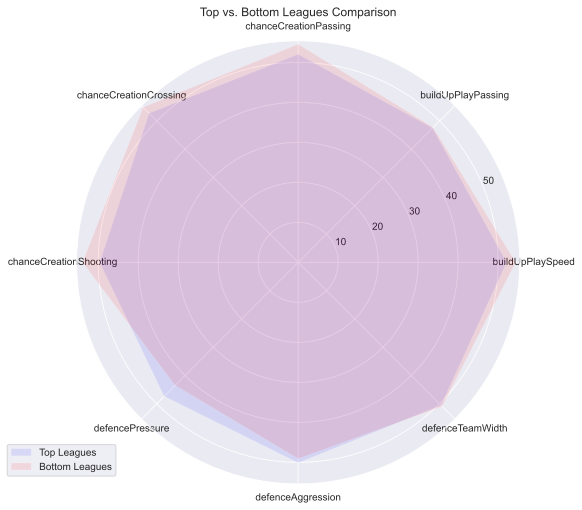

<IPython.core.display.Javascript object>

In [22]:
features = league_avg_attr_df_num.iloc[:, 1:].columns.tolist()
top_leagues_data = league_avg_attr_df_num[league_avg_attr_df_num.leagues == 'top_leagues'].iloc[:,1:].values.tolist()[0]
bottom_leagues_data = league_avg_attr_df_num[league_avg_attr_df_num.leagues == 'bottom_leagues'].iloc[:,1:].values.tolist()[0]

hf.plot_radial_graph_two_groups(features, top_leagues_data, bottom_leagues_data,
                             cat_1_label='Top Leagues', cat_2_label='Bottom Leagues', 
                             plot_title="Top vs. Bottom Leagues Comparison")

The average team attributes across the top-3 and bottom-3 leagues (by the goals per match ratio) are generally similar. Though top leagues tend to have higher defence pressure and defence aggression.

## 1.4. What teams are the top scorers in each league and overall(by # of goals per match)?

#### Main insights and observations:
- Top-5 teams overall (by # of goals per game):
    - Real Madrid CF
    - FC Barcelona
    - FC Bayern Munich
    - PSV
    - Celtic

- Bottom-5 teams overall (by # of goals per game):
    - Córdoba CF
    - FC Penafiel
    - 1.FC Kaiserslautern
    - FC Dordrecht
    - Pescara

    
- We can observe that top teams tend to have higher share of home wins as opposed to the worst teams (by # of goals per game).

In [23]:
seasonly_goals_df = pd.read_sql(
    """    
        WITH team_goals AS (
            SELECT
                season,
                league_name,
                team_api_id,
                SUM(home_goals) AS home_goals,
                SUM(home_games) AS home_games,
                SUM(away_goals) AS away_goals,
                SUM(away_games) AS away_games
            FROM (
                SELECT
                    season,
                    league_name,
                    home_team_api_id AS team_api_id,
                    SUM(home_team_goal) AS home_goals,
                    COUNT(home_team_goal) AS home_games,
                    0 AS away_goals,
                    0 AS away_games
                FROM long_match_info
                GROUP BY 1, 2, 3
        
                UNION ALL
        
                SELECT
                    season,
                    league_name,
                    away_team_api_id AS team_api_id,
                    0 AS home_goals,
                    0 AS home_games,
                    SUM(away_team_goal) AS away_goals,
                    COUNT(away_team_goal) AS away_games
                FROM long_match_info
                GROUP BY 1, 2, 3
            ) subquery
            GROUP BY season, league_name, team_api_id
        )
        
        SELECT DISTINCT
            tg.season,
            tg.league_name,
            ti.team_long_name AS team_name,
            tg.home_goals AS goals_home,
            tg.away_goals AS goals_away,
            tg.home_goals + tg.away_goals as total_goals,
            tg.home_games AS games_home,
            tg.away_games AS games_away,
            tg.home_games + tg.away_games AS total_games,
            ROUND((tg.home_goals + tg.away_goals) * 1.0 / 
                  (tg.home_games + tg.away_games), 2) 
            AS goals_per_game
        FROM team_goals tg
        JOIN team_info ti
            ON tg.team_api_id = ti.team_api_id
        ORDER BY 1, 2, 3;
        """,
    conn,
)
seasonly_goals_df

,season,league_name,team_name,goals_home,goals_away,total_goals,games_home,games_away,total_games,goals_per_game
0,2011/2012,Belgium Jupiler League,Beerschot AC,19,14,33,12,11,23,1.43
1,2011/2012,Belgium Jupiler League,Club Brugge KV,30,20,50,15,14,29,1.72
2,2011/2012,Belgium Jupiler League,KAA Gent,33,22,55,13,13,26,2.12
3,2011/2012,Belgium Jupiler League,KRC Genk,31,23,54,13,14,27,2.00
4,2011/2012,Belgium Jupiler League,KSV Cercle Brugge,14,16,30,13,14,27,1.11
...,...,...,...,...,...,...,...,...,...,...
780,2015/2016,Spain LIGA BBVA,SD Eibar,22,21,43,17,18,35,1.23
781,2015/2016,Spain LIGA BBVA,Sevilla FC,38,11,49,19,17,36,1.36
782,2015/2016,Spain LIGA BBVA,UD Las Palmas,21,15,36,15,16,31,1.16
783,2015/2016,Spain LIGA BBVA,Valencia CF,25,21,46,18,19,37,1.24


<IPython.core.display.Javascript object>

Note: this combined table contains info on the number of goals and games that each team played. When grouping this table by leagues, the number of games should be divided by 2 to avoid double counting.

In [24]:
team_goals_df = seasonly_goals_df.iloc[:,1:-1].groupby(['league_name', 'team_name']).sum().reset_index()
team_goals_df['goals_per_game'] = round((team_goals_df['total_goals']/team_goals_df['total_games']), 2)

top_5_teams = team_goals_df.groupby(['league_name']).apply(lambda x: x.nlargest(5, 'goals_per_game')).reset_index(drop=True)
bottom_5_teams = team_goals_df.groupby(['league_name']).apply(lambda x: x.nsmallest(5, 'goals_per_game')).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [25]:
for league in top_5_teams.league_name.unique().tolist():
    print(f"Top-5 teams in {league}:")
    teams = top_5_teams[top_5_teams.league_name == league].team_name.tolist()
    for team in teams:
        print("*", team)
    print("-"*30)

Top-5 teams in Belgium Jupiler League:
* Club Brugge KV
* RSC Anderlecht
* KAA Gent
* KRC Genk
* RAEC Mons
------------------------------
Top-5 teams in England Premier League:
* Manchester City
* Manchester United
* Arsenal
* Chelsea
* Liverpool
------------------------------
Top-5 teams in France Ligue 1:
* Paris Saint-Germain
* Olympique Lyonnais
* AS Monaco
* Olympique de Marseille
* LOSC Lille
------------------------------
Top-5 teams in Germany 1. Bundesliga:
* FC Bayern Munich
* Borussia Dortmund
* Bayer 04 Leverkusen
* FC Schalke 04
* VfL Wolfsburg
------------------------------
Top-5 teams in Italy Serie A:
* Juventus
* Napoli
* Roma
* Milan
* Fiorentina
------------------------------
Top-5 teams in Netherlands Eredivisie:
* PSV
* Ajax
* Feyenoord
* FC Twente
* SC Heerenveen
------------------------------
Top-5 teams in Portugal Liga ZON Sagres:
* SL Benfica
* FC Porto
* Sporting CP
* SC Braga
* CD Nacional
------------------------------
Top-5 teams in Scotland Premier League

<IPython.core.display.Javascript object>

In [26]:
top_1_teams = top_5_teams.groupby(['league_name']).apply(lambda x: x.nlargest(1, 'goals_per_game')).reset_index(drop=True)
top_1_teams

,league_name,team_name,goals_home,goals_away,total_goals,games_home,games_away,total_games,goals_per_game
0,Belgium Jupiler League,Club Brugge KV,132,107,239,58,57,115,2.08
1,England Premier League,Manchester City,246,161,407,94,94,188,2.16
2,France Ligue 1,Paris Saint-Germain,238,165,403,95,91,186,2.17
3,Germany 1. Bundesliga,FC Bayern Munich,250,179,429,85,85,170,2.52
4,Italy Serie A,Juventus,195,156,351,91,90,181,1.94
5,Netherlands Eredivisie,PSV,236,190,426,84,85,169,2.52
6,Portugal Liga ZON Sagres,SL Benfica,166,125,291,61,62,123,2.37
7,Scotland Premier League,Celtic,235,189,424,89,87,176,2.41
8,Spain LIGA BBVA,Real Madrid CF,328,219,547,93,94,187,2.93


<IPython.core.display.Javascript object>

In [27]:
bottom_1_teams = bottom_5_teams.groupby(['league_name']).apply(lambda x: x.nsmallest(1, 'goals_per_game')).reset_index(drop=True)
bottom_1_teams

,league_name,team_name,goals_home,goals_away,total_goals,games_home,games_away,total_games,goals_per_game
0,Belgium Jupiler League,Lierse SK,41,30,71,38,41,79,0.90
1,England Premier League,Burnley,14,14,28,19,19,38,0.74
2,France Ligue 1,Stade Brestois 29,39,24,63,38,38,76,0.83
3,Germany 1. Bundesliga,1. FC Kaiserslautern,12,12,24,17,17,34,0.71
4,Italy Serie A,Pescara,15,12,27,19,18,37,0.73
5,Netherlands Eredivisie,FC Dordrecht,13,8,21,15,14,29,0.72
6,Portugal Liga ZON Sagres,FC Penafiel,4,3,7,4,6,10,0.70
7,Scotland Premier League,St. Mirren,72,63,135,67,67,134,1.01
8,Spain LIGA BBVA,Córdoba CF,12,9,21,19,18,37,0.57


<IPython.core.display.Javascript object>

In [28]:
best_10_overall = team_goals_df.nlargest(10, 'goals_per_game')
worst_10_overall = team_goals_df.nsmallest(10, 'goals_per_game')
print("Top-10 teams overall (by # of goals per game):")
print(best_10_overall.team_name.tolist())
print("-"*30)
print("Bottom-10 teams overall (by # of goals per game):")
print(worst_10_overall.team_name.tolist())

Top-10 teams overall (by # of goals per game):
['Real Madrid CF', 'FC Barcelona', 'FC Bayern Munich', 'PSV', 'Celtic', 'SL Benfica', 'Ajax', 'Borussia Dortmund', 'Paris Saint-Germain', 'Manchester City']
------------------------------
Bottom-10 teams overall (by # of goals per game):
['Córdoba CF', 'FC Penafiel', '1. FC Kaiserslautern', 'FC Dordrecht', 'Pescara', 'Burnley', 'Racing Santander', 'SpVgg Greuther Fürth', 'Carpi', 'Stade Brestois 29']


<IPython.core.display.Javascript object>

Now we have the lists of best and worst teams by # of goals per game ratio. We are also interested in the share of home and away goals for those teams, so we will plot it below:

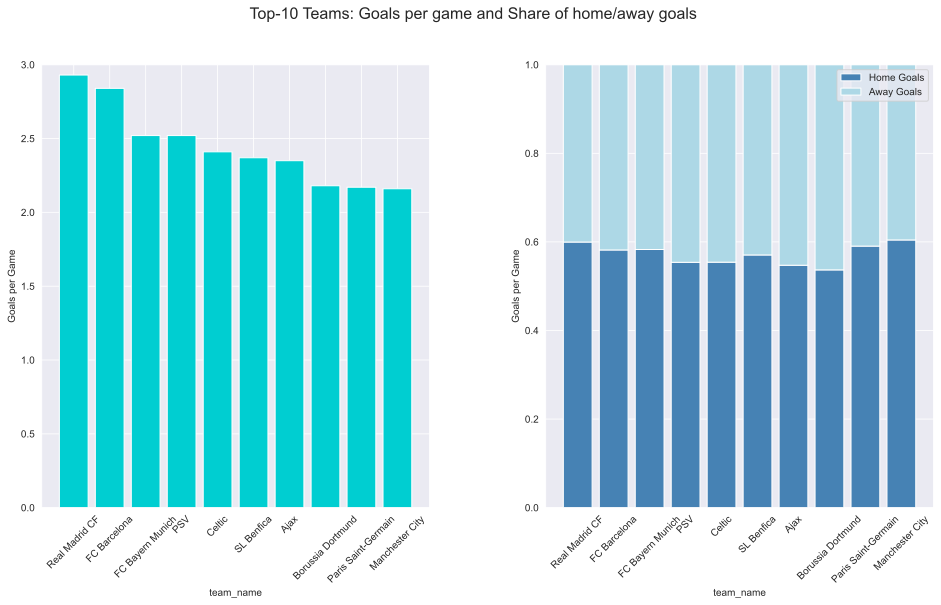

<IPython.core.display.Javascript object>

In [29]:
hf.visualize_double_barplot(best_10_overall, my_title='Top-10 Teams: Goals per game and Share of home/away goals',
                        cat_col='team_name', plot1_y_label='Goals per Game',
                        plot1_x_col='goals_per_game',
                        plot2_group1_col='goals_home',
                        plot2_group2_col='goals_away',
                        group1_label='Home Goals',
                        group2_label='Away Goals',
                        ylim_left=[0, 3])

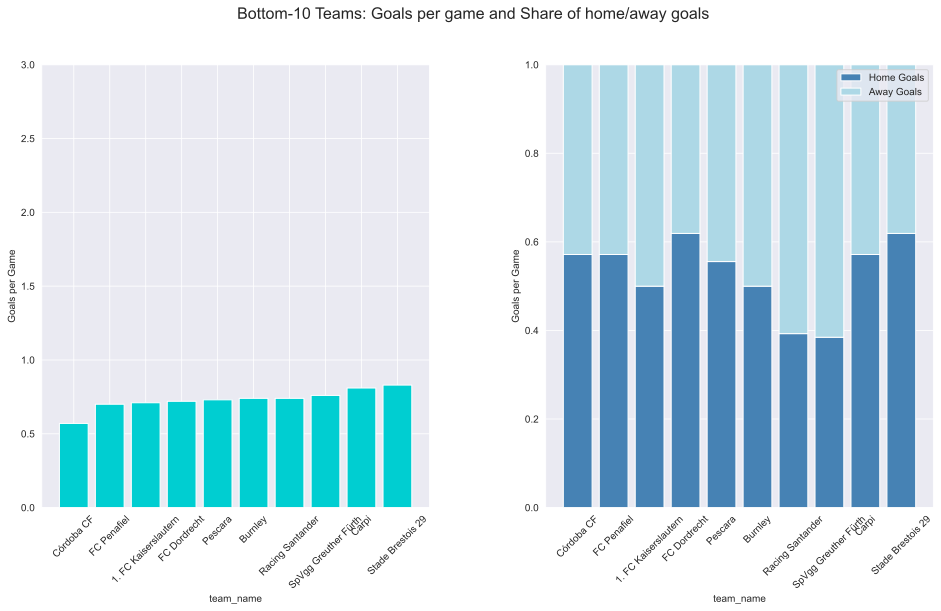

<IPython.core.display.Javascript object>

In [30]:
hf.visualize_double_barplot(worst_10_overall, my_title='Bottom-10 Teams: Goals per game and Share of home/away goals',
                        cat_col='team_name', plot1_y_label='Goals per Game',
                        plot1_x_col='goals_per_game',
                        plot2_group1_col='goals_home',
                        plot2_group2_col='goals_away',
                        group1_label='Home Goals',
                        group2_label='Away Goals',
                        ylim_left=[0, 3])

- We can observe that top teams tend to have higher share of home wins as opposed to the worst teams (by # of goals per game). 

## 1.5. What are the top and bottom teams by win percentage (total/home/away)?

#### Main insights and observations:

- The top-5 teams overall (by the win percentage):
    - FC Bayern Munich
    - SL Benfica
    - FC Barcelona
    - Real Madrid CF
    - Celtic
      

- The bottom-5 teams overall (by the win percentage):
    - Córdoba CF
    - FC Dordrecht
    - Racing Santander
    - Cesena
    - 1.FC Kaiserslautern

- The lists of top and bottom teams by overall win percentage and by goals-per-game ratio are a bit different. That may mean that some teams win more often with lower goal count during the match.

In [31]:
seasonly_team_wins = pd.read_sql(
    """
    WITH home_wins AS (
      SELECT 
        season,
        home_team_name AS team_name,
        COUNT(*) AS home_wins
      FROM long_match_info
      WHERE home_team_name = match_winner
      GROUP BY season, home_team_name
    ),
    
    away_wins AS (
      SELECT 
        season,
        away_team_name AS team_name,
        COUNT(*) AS away_wins
      FROM long_match_info
      WHERE away_team_name = match_winner
      GROUP BY season, away_team_name
    ),

    total_games AS (
    SELECT DISTINCT
      season,
      team_name,
      COUNT(*) AS total_games
    FROM (
      SELECT season, 
             home_team_name AS team_name 
      FROM long_match_info
      UNION ALL
      SELECT season, 
             away_team_name AS team_name 
      FROM long_match_info
    ) AS all_teams
    GROUP BY season, team_name
  )

  SELECT 
    COALESCE(h.season, a.season) AS season,
    COALESCE(h.team_name, a.team_name) AS team_name,
    COALESCE(h.home_wins, 0) AS home_wins,
    COALESCE(a.away_wins, 0) AS away_wins,
    COALESCE(h.home_wins, 0) + COALESCE(a.away_wins, 0) AS total_wins,
    COALESCE(t.total_games, 0) AS total_games,
    ROUND((COALESCE(h.home_wins, 0) + COALESCE(a.away_wins, 0)) * 100.0 / NULLIF(t.total_games, 0), 2) AS win_percentage
  FROM home_wins h
  FULL JOIN away_wins a ON h.team_name = a.team_name AND h.season = a.season
  INNER JOIN total_games t ON h.team_name = t.team_name AND h.season = t.season
  GROUP BY h.season, h.team_name
  ORDER BY h.season, win_percentage DESC;
    """,
    conn
)
seasonly_team_wins.head()

,season,team_name,home_wins,away_wins,total_wins,total_games,win_percentage
0,2011/2012,Real Madrid CF,16,16,32,38,84.21
1,2011/2012,Celtic,16,12,28,35,80.00
2,2011/2012,FC Porto,8,9,17,22,77.27
3,2011/2012,Manchester United,15,13,28,38,73.68
4,2011/2012,Borussia Dortmund,14,11,25,34,73.53


<IPython.core.display.Javascript object>

In [32]:
wins_by_team = seasonly_team_wins.groupby('team_name').sum(numeric_only=True).reset_index()
wins_by_team['win_percentage'] = round(wins_by_team['total_wins']/wins_by_team['total_games'] * 100, 2)
wins_by_team = wins_by_team.sort_values(by=['win_percentage'], ascending=False).reset_index(drop=True) 

<IPython.core.display.Javascript object>

In [33]:
wins_by_team.nlargest(10, 'win_percentage')

,team_name,home_wins,away_wins,total_wins,total_games,win_percentage
0,FC Bayern Munich,72,62,134,170,78.82
1,SL Benfica,51,44,95,123,77.24
2,FC Barcelona,78,63,141,185,76.22
3,Real Madrid CF,79,61,140,187,74.87
4,Celtic,72,59,131,176,74.43
5,Juventus,75,57,132,181,72.93
6,FC Porto,51,37,88,125,70.40
7,Rangers,12,14,26,37,70.27
8,PSV,68,47,115,169,68.05
9,Paris Saint-Germain,72,53,125,186,67.20


<IPython.core.display.Javascript object>

In [34]:
wins_by_team.nsmallest(10, 'win_percentage')

,team_name,home_wins,away_wins,total_wins,total_games,win_percentage
219,Córdoba CF,1,1,2,37,5.41
218,FC Dordrecht,2,1,3,29,10.34
217,Racing Santander,3,1,4,38,10.53
216,Cesena,3,2,5,44,11.36
215,1. FC Kaiserslautern,2,2,4,34,11.76
214,Wolverhampton Wanderers,3,2,5,38,13.16
213,ES Troyes AC,6,4,10,73,13.70
212,Dunfermline Athletic,1,4,5,36,13.89
211,De Graafschap,4,3,7,49,14.29
210,SC Beira Mar,5,2,7,47,14.89


<IPython.core.display.Javascript object>

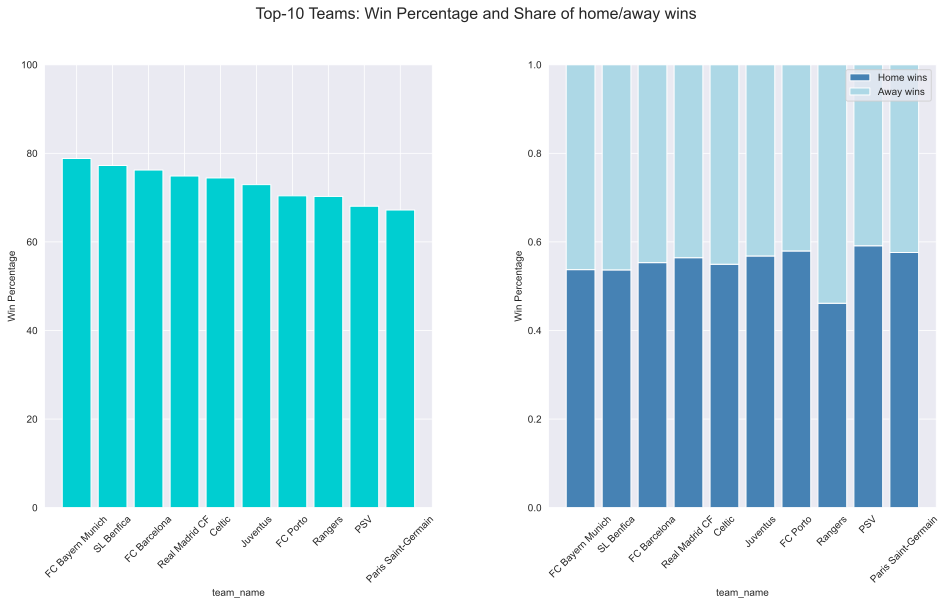

<IPython.core.display.Javascript object>

In [35]:
hf.visualize_double_barplot(wins_by_team.nlargest(10, 'win_percentage'), my_title='Top-10 Teams: Win Percentage and Share of home/away wins',
                            cat_col='team_name', plot1_y_label='Win Percentage',
                            plot1_x_col='win_percentage',
                            plot2_group1_col='home_wins',
                            plot2_group2_col='away_wins',
                            group1_label='Home wins',
                            group2_label='Away wins',
                            ylim_left=[0, 100])

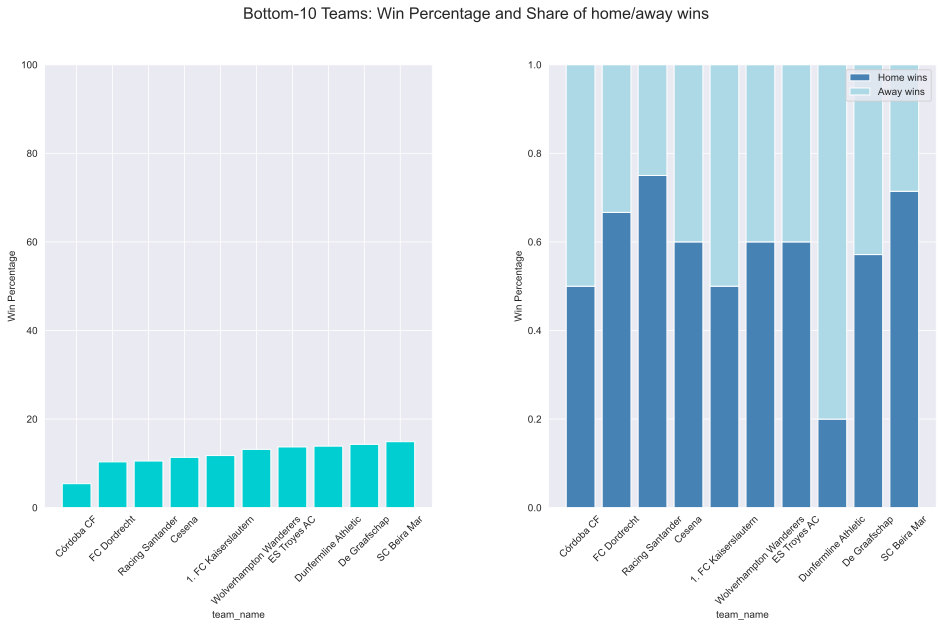

<IPython.core.display.Javascript object>

In [36]:
hf.visualize_double_barplot(wins_by_team.nsmallest(10, 'win_percentage'), my_title='Bottom-10 Teams: Win Percentage and Share of home/away wins',
                            cat_col='team_name', plot1_y_label='Win Percentage',
                            plot1_x_col='win_percentage',
                            plot2_group1_col='home_wins',
                            plot2_group2_col='away_wins',
                            group1_label='Home wins',
                            group2_label='Away wins',
                            ylim_left=[0, 100])

## 1.6. What are the top and bottom players in each league and overall (by overall rating)?

#### Main insights and observations:

- Based on the overall rating given in the original dataset (averaged across all seasons), the top-5 players are:
    - Lionel Messi (Spain LIGA BBVA, FC Barcelona)
    - Cristiano Ronaldo (Spain LIGA BBVA, Real Madrid CF)
    - Andres Iniesta (Spain LIGA BBVA, FC Barcelona)
    - Arjen Robben (Germany 1. Bundesliga, FC Bayern Munich)
    - Zlatan Ibrahimovic (Italy Serie A, Milan)
- The top-3 players overall are from the league called Spain LIGA BBVA. This league is in top-3 based on the total # of goals, but not in top-3 by goals-per-match ratio.
- 2 out of 3 top players are from the FC Barcelona team, which is in top-3 teams by goals-per-game ratio and win percentage.
- One top player - Zlatan Ibrahimovic - is from league Italy Serie A, which is in the bottom-3 leagues by goals-per-game ratio. It's possible that other leagues' teams will notice this player and will try to win him over.
- The top-3 leagues by mean player overall rating are:
    - Spain LIGA BBVA
    - England Premier League
    - Germany 1. Bundesliga
- Average overal player ratings in a league seem to not be very correlated with the # of goals per game.

In [37]:
home_players = pd.read_sql(
    """
    SELECT 
         league_name, 
         home_team_name AS team_name, 
         CAST(lmi.home_player_1 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_2 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_3 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_4 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_5 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_6 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_7 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_8 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_9 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_10 AS INTEGER) || ', ' || 
         CAST(lmi.home_player_11 AS INTEGER) 
         AS player_ids
    FROM long_match_info lmi
    GROUP BY 1, 2;
""", 
conn
)
home_players['player_ids_list'] = home_players['player_ids'].str.split(', ').apply(lambda x: [int(id) for id in x])
home_players.drop(columns=['player_ids'], inplace=True)

<IPython.core.display.Javascript object>

In [38]:
away_players = pd.read_sql(
    """
    SELECT 
         league_name, 
         away_team_name AS team_name, 
         CAST(lmi.away_player_1 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_2 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_3 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_4 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_5 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_6 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_7 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_8 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_9 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_10 AS INTEGER) || ', ' || 
         CAST(lmi.away_player_11 AS INTEGER) 
         AS player_ids
    FROM long_match_info lmi
    GROUP BY 1, 2
""", 
conn
)
away_players['player_ids_list'] = away_players['player_ids'].str.split(', ').apply(lambda x: [int(id) for id in x])
away_players.drop(columns=['player_ids'], inplace=True)

<IPython.core.display.Javascript object>

In [39]:
def combine_and_get_unique(row):
    combined_list = set(row['player_ids_list_x'] + row['player_ids_list_y'])
    return list(combined_list)

all_players = pd.merge(home_players, away_players, on=['league_name', 'team_name'])
all_players['player_ids'] = all_players.apply(combine_and_get_unique, axis=1)
all_players.drop(columns=['player_ids_list_x', 'player_ids_list_y'], inplace=True)
all_players.head()

,league_name,team_name,player_ids
0,Belgium Jupiler League,Beerschot AC,"[38784, 38371, 14487, 36873, 166679, 131408, 3..."
1,Belgium Jupiler League,Club Brugge KV,"[36832, 38336, 42594, 38366, 277770, 113868, 2..."
2,Belgium Jupiler League,KAA Gent,"[114368, 37440, 104378, 37667, 148329, 49451, ..."
3,Belgium Jupiler League,KRC Genk,"[38368, 42153, 39498, 38794, 169200, 109331, 4..."
4,Belgium Jupiler League,KSV Cercle Brugge,"[36835, 38789, 38342, 27110, 277766, 173449, 3..."


<IPython.core.display.Javascript object>

In [40]:
all_players = all_players.explode(['player_ids'], ignore_index=True)
all_players = all_players.rename(columns={'player_ids': 'player_api_id'})
all_players.head()

,league_name,team_name,player_api_id
0,Belgium Jupiler League,Beerschot AC,38784
1,Belgium Jupiler League,Beerschot AC,38371
2,Belgium Jupiler League,Beerschot AC,14487
3,Belgium Jupiler League,Beerschot AC,36873
4,Belgium Jupiler League,Beerschot AC,166679


<IPython.core.display.Javascript object>

In [41]:
player_ratings = pd.read_sql(
    """
    SELECT p.player_api_id,
           p.player_name,
           ROUND(AVG(p.overall_rating), 2) AS avg_overall_rating
    FROM player_info p
    GROUP BY player_name
    ORDER BY avg_overall_rating DESC
""", 
conn
)
player_ratings.head()

,player_api_id,player_name,avg_overall_rating
0,30981,Lionel Messi,93.80
1,30893,Cristiano Ronaldo,92.20
2,30955,Andres Iniesta,89.40
3,39854,Xavi Hernandez,89.00
4,35724,Zlatan Ibrahimovic,88.88


<IPython.core.display.Javascript object>

In [42]:
player_ratings_full = pd.merge(all_players, player_ratings, on='player_api_id')
player_ratings_full.head()

,league_name,team_name,player_api_id,player_name,avg_overall_rating
0,Belgium Jupiler League,Beerschot AC,38784,Wim De Decker,65.00
1,Belgium Jupiler League,Beerschot AC,38371,Bart Goor,66.00
2,Belgium Jupiler League,Beerschot AC,14487,Roei Dayan,65.63
3,Belgium Jupiler League,Beerschot AC,36873,Kristof Maes,56.75
4,Belgium Jupiler League,Beerschot AC,166679,Guillaume Francois,64.05


<IPython.core.display.Javascript object>

In [43]:
player_ratings_full.nlargest(5, 'avg_overall_rating')

,league_name,team_name,player_api_id,player_name,avg_overall_rating
2581,Spain LIGA BBVA,FC Barcelona,30981,Lionel Messi,93.80
2753,Spain LIGA BBVA,Real Madrid CF,30893,Cristiano Ronaldo,92.20
2583,Spain LIGA BBVA,FC Barcelona,30955,Andres Iniesta,89.40
1172,Germany 1. Bundesliga,FC Bayern Munich,30834,Arjen Robben,88.88
1597,Italy Serie A,Milan,35724,Zlatan Ibrahimovic,88.88


<IPython.core.display.Javascript object>

In [44]:
player_ratings_full.nsmallest(5, 'avg_overall_rating')

,league_name,team_name,player_api_id,player_name,avg_overall_rating
2362,Scotland Premier League,Dunfermline Athletic,8925,Ryan Thomson,52.00
62,Belgium Jupiler League,KSV Cercle Brugge,38251,Dominic Foley,55.00
2354,Scotland Premier League,Dunfermline Athletic,470412,Paul Willis,55.00
2401,Scotland Premier League,Hibernian,183414,David Stephens,55.07
2473,Scotland Premier League,Ross County FC,32620,Sam Morrow,56.20


<IPython.core.display.Javascript object>

- Based on the overall rating given in the original dataset (averaged across all seasons), the top-5 players are:
    - Lionel Messi (Spain LIGA BBVA, FC Barcelona)
    - Cristiano Ronaldo (Spain LIGA BBVA, Real Madrid CF)
    - Andres Iniesta (Spain LIGA BBVA, FC Barcelona)
    - Arjen Robben (Germany 1. Bundesliga, FC Bayern Munich)
    - Zlatan Ibrahimovic (Italy Serie A, Milan)
- The top-3 players overall are from the league called Spain LIGA BBVA. This league is in top-3 based on the total # of goals, but not in top-3 by goals-per-match ratio.
- 2 out of 3 top players are from the FC Barcelona team, which is in top-3 teams by goals-per-game ratio and win percentage.
- One top player is from league Italy Serie A, which is in the bottom-3 leagues by goals-per-game ratio. It's possible that other leagues' teams will notice this player and will try to win him over.

In [45]:
mean_rating_by_league = player_ratings_full.groupby('league_name')['avg_overall_rating']\
                                             .apply(lambda x: x.mean()).reset_index()\
                                             .sort_values(by='avg_overall_rating', ascending=False)\
                                             .rename(columns={'avg_overall_rating': 'mean_rating'})
mean_rating_by_league

,league_name,mean_rating
8,Spain LIGA BBVA,74.127884
1,England Premier League,73.633990
3,Germany 1. Bundesliga,73.305798
4,Italy Serie A,73.121152
2,France Ligue 1,71.294855
6,Portugal Liga ZON Sagres,70.111794
5,Netherlands Eredivisie,68.367402
0,Belgium Jupiler League,66.544883
7,Scotland Premier League,63.838143


<IPython.core.display.Javascript object>

- The top-3 leagues by mean player overall rating are:
    - Spain LIGA BBVA
    - England Premier League
    - Germany 1. Bundesliga 

In [46]:
player_ratings_full.groupby('league_name').apply(lambda x: x.nlargest(1, 'avg_overall_rating')).reset_index(drop=True)

,league_name,team_name,player_api_id,player_name,avg_overall_rating
0,Belgium Jupiler League,KRC Genk,169200,Kevin de Bruyne,80.81
1,England Premier League,Liverpool,40636,Luis Suarez,87.53
2,France Ligue 1,LOSC Lille,107417,Eden Hazard,86.81
3,Germany 1. Bundesliga,FC Bayern Munich,30834,Arjen Robben,88.88
4,Italy Serie A,Milan,35724,Zlatan Ibrahimovic,88.88
5,Netherlands Eredivisie,Ajax,157723,Christian Eriksen,81.49
6,Portugal Liga ZON Sagres,FC Porto,164684,James Rodriguez,83.75
7,Scotland Premier League,Rangers,8922,Nikica Jelavic,75.14
8,Spain LIGA BBVA,FC Barcelona,30981,Lionel Messi,93.80


<IPython.core.display.Javascript object>

In [47]:
player_ratings_full.groupby('league_name').apply(lambda x: x.nsmallest(1, 'avg_overall_rating')).reset_index(drop=True)

,league_name,team_name,player_api_id,player_name,avg_overall_rating
0,Belgium Jupiler League,KSV Cercle Brugge,38251,Dominic Foley,55.00
1,England Premier League,Queens Park Rangers,30355,Patrick Agyemang,61.11
2,France Ligue 1,Dijon FCO,40017,Lesly Malouda,59.83
3,Germany 1. Bundesliga,FC Augsburg,42715,Lorenzo Davids,62.38
4,Italy Serie A,Frosinone,415500,Mirko Gori,58.50
5,Netherlands Eredivisie,SC Cambuur,169294,Oliver Feldballe,58.63
6,Portugal Liga ZON Sagres,FC Arouca,186668,Luis Dias,59.00
7,Scotland Premier League,Dunfermline Athletic,8925,Ryan Thomson,52.00
8,Spain LIGA BBVA,Racing Santander,169198,Jose Picon,61.00


<IPython.core.display.Javascript object>

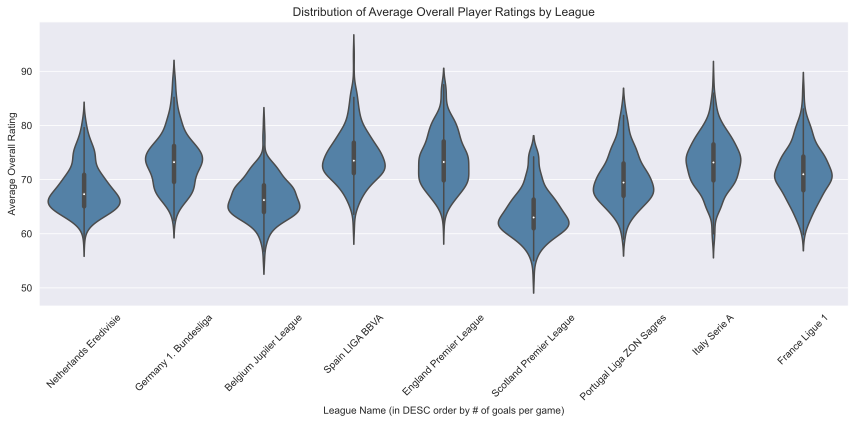

<IPython.core.display.Javascript object>

In [48]:
best_leagues_order = league_scores.sort_values(by=['goals_per_match_ratio'], 
                                               ascending=False)['league_name'].tolist()

plt.figure(figsize=(12, 6))
sns.violinplot(data=player_ratings_full, x='league_name', y='avg_overall_rating', 
               palette=['steelblue'], order=best_leagues_order)
plt.xticks(rotation=45)  
plt.title('Distribution of Average Overall Player Ratings by League')
plt.xlabel('League Name (in DESC order by # of goals per game)')
plt.ylabel('Average Overall Rating')
plt.tight_layout()
plt.show()

- Average overal player ratings in a league seem to not be very correlated with the # of goals per game.

## 1.7. How does win percentage correlate with goals per game ratio?  How do mean player ratings correlate with win percentage for teams?

#### Main insights and observations:
- There is a very high correlation between the team win percentage and goals per game ratio (Pearson: 0.92).
- The correlation between the win percentage and mean overall player rating is moderate (Pearson: 0.58). Only 34% of the variability in the win percentage can be explained by the mean player rating.

In [49]:
mean_rating_by_team = player_ratings_full.groupby('team_name')['avg_overall_rating']\
                                         .apply(lambda x: round(x.mean(), 2)).reset_index()\
                                         .sort_values(by='avg_overall_rating', ascending=False)\
                                         .rename(columns={'avg_overall_rating': 'mean_player_rating'})
mean_rating_by_team.head()

,team_name,mean_player_rating
61,FC Barcelona,84.24
62,FC Bayern Munich,84.02
154,Real Madrid CF,82.34
116,Manchester City,81.89
26,Borussia Dortmund,80.29


<IPython.core.display.Javascript object>

In [50]:
goals_wins_by_team = pd.merge(team_goals_df.iloc[:,[1,-1]], wins_by_team.iloc[:,[0,-1]], on=['team_name'])
goals_wins_ratings_by_team = pd.merge(goals_wins_by_team, mean_rating_by_team, on=['team_name'])
goals_wins_ratings_by_team.head()

,team_name,goals_per_game,win_percentage,mean_player_rating
0,Beerschot AC,1.26,26.00,65.20
1,Club Brugge KV,2.08,59.13,69.65
2,KAA Gent,1.69,47.37,68.89
3,KRC Genk,1.67,44.74,70.51
4,KSV Cercle Brugge,0.95,22.62,65.06


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Correlation Between Goals per Game and Win Percentage (Pearson Correlation: 0.92, R-squared: 0.85)')

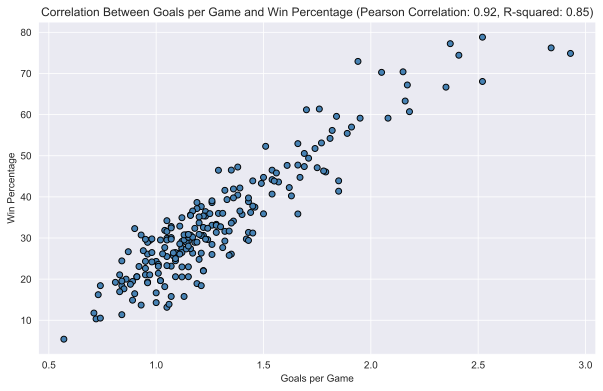

<IPython.core.display.Javascript object>

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(goals_wins_ratings_by_team['goals_per_game'], goals_wins_ratings_by_team['win_percentage'], marker='o', color='steelblue', edgecolors='black')

corr, _ = stats.pearsonr(goals_wins_ratings_by_team['goals_per_game'], goals_wins_ratings_by_team['win_percentage'])
r_squared = corr**2

plt.xlabel('Goals per Game')
plt.ylabel('Win Percentage')
plt.title(f'Correlation Between Goals per Game and Win Percentage (Pearson Correlation: {corr:.2f},'+ 
            f' R-squared: {r_squared:.2f})')

- There is a very high correlation between the team win percentage and goals per game ratio. 

Text(0.5, 1.0, 'Correlation Between Win Percentage and Mean Player Rating (Pearson Correlation: 0.58, R-squared: 0.34)')

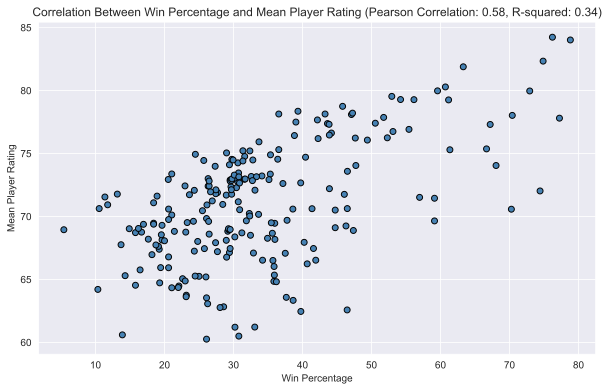

<IPython.core.display.Javascript object>

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(goals_wins_ratings_by_team['win_percentage'], goals_wins_ratings_by_team['mean_player_rating'], marker='o', color='steelblue', edgecolors='black')

corr, _ = stats.pearsonr(goals_wins_ratings_by_team['win_percentage'], goals_wins_ratings_by_team['mean_player_rating'])
r_squared = corr**2

plt.xlabel('Win Percentage')
plt.ylabel('Mean Player Rating')
plt.title(f'Correlation Between Win Percentage and Mean Player Rating (Pearson Correlation: {corr:.2f},'+ 
            f' R-squared: {r_squared:.2f})')

- The correlation between the win percentage and mean overall player rating is moderate. Only 34% of the variability in the win percentage can be explained by the mean player rating.

## 1.8. How do team attributes compare between the top/bottom teams (by win percentage)?

#### Main insights and observations:
- The top teams tend to have higher mean values for defence pressure, defence aggression.
- The bottom teams tend to have higher mean values for build-up play passing, build-up play speed, and chance creation passing.
- When we anayze all teams, there is no strong correlation between the team attributes and the win percentage. The only attributes that have some moderate correlation are:
    - mean_player_rating
    - defence pressure
    - defence aggression
    - and some negative light correlation with build-up play passing.

#### Additional notes:
- chanceCreationPassing - Accuracy of passing to create chances
- chanceCreationCrossing - Quality of crosses to create chances
- chanceCreationShooting - Ability to shoot and create chances
- buildUpPlaySpeed - How fast they move the ball up the field
- buildUpPlayPassing - Accuracy of their passing to move up the field
- defencePressure - How much they pressure opponents
- defenceAggression - Aggressiveness of their defending
- defenceTeamWidth - How compact or spread out they defend

In [53]:
top_20_winning_teams = goals_wins_ratings_by_team.nlargest(20, 'win_percentage')['team_name'].tolist()
bottom_20_winning_teams = goals_wins_ratings_by_team.nsmallest(20, 'win_percentage')['team_name'].tolist()

<IPython.core.display.Javascript object>

In [54]:
placeholder_win = ', '.join(['?'] * len(top_20_winning_teams))

query = f"""
           SELECT t.* 
           FROM team_info t
           JOIN long_match_info lmi 
           ON t.team_api_id = lmi.home_team_api_id
           WHERE lmi.home_team_name IN ({placeholder_win}) 
            """
result = c.execute(query, top_20_winning_teams)
rows = result.fetchall()
top_team_attr = pd.DataFrame(rows, columns=[column[0] for column in result.description])
top_team_attr.head()

,season,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,...,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,2011/2012,8342,64.0,54.0,48.0,61.0,47.0,60.0,50.0,52.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,2013/2014,8342,45.0,48.0,48.0,61.0,47.0,43.0,59.0,45.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,2014/2015,8342,42.0,45.0,42.0,57.0,47.0,51.0,50.0,57.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,2015/2016,8342,42.0,45.0,42.0,57.0,47.0,51.0,50.0,57.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
4,2011/2012,9789,71.0,45.0,67.0,44.0,70.0,58.0,69.0,46.0,...,Mixed,Organised,Risky,Normal,Lots,Free Form,Medium,Double,Normal,Cover


<IPython.core.display.Javascript object>

In [55]:
top_team_attr_all = top_team_attr.copy()

columns_to_drop = ['season', 'team_api_id', 'team_long_name', 'team_short_name']
top_team_attr_all.drop(columns=columns_to_drop, inplace=True)

numeric_cols = top_team_attr_all.select_dtypes('number').columns.tolist()
categorical_cols = top_team_attr_all.select_dtypes('object', 'datetime64').columns.tolist()

top_team_attr_all[numeric_cols] = top_team_attr_all[numeric_cols].mean()
for col in categorical_cols:
    mode_val = top_team_attr_all[col].mode().iloc[0]
    top_team_attr_all[col] = top_team_attr_all[col].fillna(mode_val)

top_team_avg_attr = top_team_attr_all.iloc[0]

<IPython.core.display.Javascript object>

In [56]:
placeholder_win_bottom = ', '.join(['?'] * len(bottom_20_winning_teams))

query = f"""
           SELECT t.* 
           FROM team_info t
           JOIN long_match_info lmi 
           ON t.team_api_id = lmi.home_team_api_id
           WHERE lmi.home_team_name IN ({placeholder_win_bottom}) 
            """
result = c.execute(query, bottom_20_winning_teams)
rows = result.fetchall()
bottom_team_attr = pd.DataFrame(rows, columns=[column[0] for column in result.description])
bottom_team_attr.head()

,season,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,...,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,2011/2012,10218,47.0,52.0,63.0,45.0,37.0,23.0,30.0,32.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Deep,Contain,Narrow,Cover
1,2015/2016,10218,53.0,69.0,48.0,45.0,43.0,29.0,41.0,36.0,...,Long,Organised,Normal,Normal,Normal,Organised,Deep,Press,Normal,Cover
2,2011/2012,8526,37.0,41.0,47.0,40.0,63.0,52.0,43.0,41.0,...,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,2011/2012,8696,43.0,44.0,61.0,71.0,50.0,50.0,50.0,68.0,...,Mixed,Organised,Normal,Lots,Normal,Organised,Medium,Press,Wide,Cover
4,2013/2014,8696,47.0,44.0,61.0,71.0,50.0,50.0,50.0,68.0,...,Mixed,Organised,Normal,Lots,Normal,Organised,Medium,Press,Wide,Cover


<IPython.core.display.Javascript object>

In [57]:
bottom_team_attr_all = bottom_team_attr.copy()

columns_to_drop = ['season', 'team_api_id', 'team_long_name', 'team_short_name']
bottom_team_attr_all.drop(columns=columns_to_drop, inplace=True)

numeric_cols = bottom_team_attr_all.select_dtypes('number').columns.tolist()
categorical_cols = bottom_team_attr_all.select_dtypes('object', 'datetime64').columns.tolist()

bottom_team_attr_all[numeric_cols] = bottom_team_attr_all[numeric_cols].mean()
for col in categorical_cols:
    mode_val = bottom_team_attr_all[col].mode().iloc[0]
    bottom_team_attr_all[col] = bottom_team_attr_all[col].fillna(mode_val)

bottom_team_avg_attr = bottom_team_attr_all.iloc[0]

<IPython.core.display.Javascript object>

In [58]:
team_avg_attr = pd.concat([top_team_avg_attr, bottom_team_avg_attr], axis=1,
                            keys=['top_teams', 'bottom_teams']).T.reset_index().rename(columns={'index': 'teams'})
team_avg_attr_df = team_avg_attr.copy()
team_avg_attr_df.index = team_avg_attr_df.teams
team_avg_attr_df.drop(columns=['teams'], inplace=True)
team_avg_attr_df.T

teams,top_teams,bottom_teams
buildUpPlaySpeed,49.500637,53.308223
buildUpPlayPassing,42.762572,53.106089
chanceCreationPassing,51.897358,53.377276
chanceCreationCrossing,53.412794,53.546139
chanceCreationShooting,52.629854,54.445072
defencePressure,52.443189,42.261142
defenceAggression,52.597868,45.237288
defenceTeamWidth,53.751432,53.151915
buildUpPlaySpeedClass,Balanced,Balanced
buildUpPlayDribblingClass,Little,Little


<IPython.core.display.Javascript object>

- The categorical features are the same for top and bottom teams. Now, we will visualize the numerical features to see the differences.

In [59]:
team_avg_attr_df_num = team_avg_attr.loc[:, 'teams':'defenceTeamWidth']
team_avg_attr_df_num

,teams,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,top_teams,49.500637,42.762572,51.897358,53.412794,52.629854,52.443189,52.597868,53.751432
1,bottom_teams,53.308223,53.106089,53.377276,53.546139,54.445072,42.261142,45.237288,53.151915


<IPython.core.display.Javascript object>

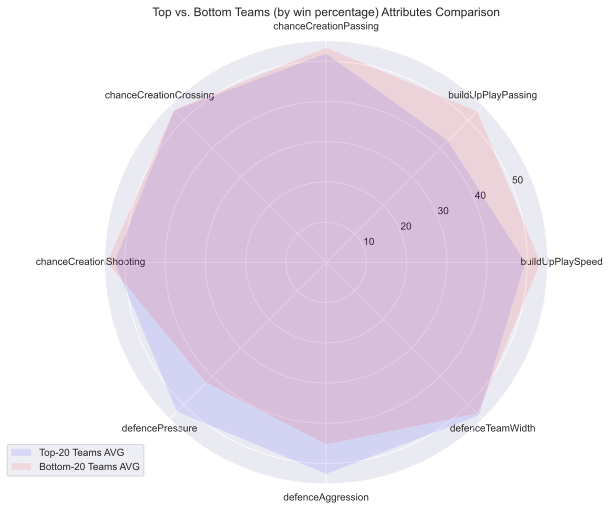

<IPython.core.display.Javascript object>

In [60]:
features = team_avg_attr_df_num.iloc[:, 1:].columns.tolist()
top_teams_data = team_avg_attr_df_num[team_avg_attr_df_num.teams == 'top_teams'].iloc[:,1:].values.tolist()[0]
bottom_teams_data = team_avg_attr_df_num[team_avg_attr_df_num.teams == 'bottom_teams'].iloc[:,1:].values.tolist()[0]

hf.plot_radial_graph_two_groups(features, top_teams_data, bottom_teams_data,
                             cat_1_label='Top-20 Teams AVG', cat_2_label='Bottom-20 Teams AVG', 
                             plot_title="Top vs. Bottom Teams (by win percentage) Attributes Comparison")

- The top teams tend to have higher mean values for defence pressure, defence aggression.
- The bottom teams tend to have higher mean values for build-up play passing, build-up play speed, and chance creation passing.

**Additional notes:**

    - chanceCreationPassing - Accuracy of passing to create chances
    - chanceCreationCrossing - Quality of crosses to create chances
    - chanceCreationShooting - Ability to shoot and create chances
    - buildUpPlaySpeed - How fast they move the ball up the field
    - buildUpPlayPassing - Accuracy of their passing to move up the field
    - defencePressure - How much they pressure opponents
    - defenceAggression - Aggressiveness of their defending
    - defenceTeamWidth - How compact or spread out they defend

In [61]:
relevant_teams_l = goals_wins_ratings_by_team.team_name.tolist()

<IPython.core.display.Javascript object>

In [62]:
placeholder = ', '.join(['?'] * len(relevant_teams_l))

query = f"""
           SELECT t.* 
           FROM team_info t
           JOIN long_match_info lmi 
           ON t.team_api_id = lmi.home_team_api_id
           WHERE lmi.home_team_name IN ({placeholder}) 
            """
result = c.execute(query, relevant_teams_l)
rows = result.fetchall()
all_team_attr = pd.DataFrame(rows, columns=[column[0] for column 
                                            in result.description]).loc[:, 'buildUpPlaySpeed':'team_long_name']
all_team_attr = all_team_attr.groupby('team_long_name').mean().reset_index()
all_team_attr.rename(columns={'team_long_name': 'team_name'}, inplace=True)
all_team_attr.head()

,team_name,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,1. FC Kaiserslautern,53.50,53.25,47.25,58.50,58.75,43.25,49.75,52.00
1,1. FC Köln,57.75,57.75,56.00,42.75,61.00,46.25,53.00,59.75
2,1. FC Nürnberg,45.50,46.25,54.00,50.75,57.25,37.50,46.75,44.50
3,1. FSV Mainz 05,65.25,54.75,53.50,38.50,51.00,52.00,63.00,51.25
4,AC Ajaccio,59.00,52.00,48.00,36.00,52.00,38.00,47.00,53.00


<IPython.core.display.Javascript object>

In [63]:
all_teams_attr_merged = pd.merge(goals_wins_ratings_by_team, all_team_attr, on=['team_name'])
all_teams_attr_merged.head()

,team_name,goals_per_game,win_percentage,mean_player_rating,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,Beerschot AC,1.26,26.00,65.20,51.00,47.00,42.50,55.00,49.00,45.00,46.00,58.50
1,Club Brugge KV,2.08,59.13,69.65,48.25,48.00,45.00,59.00,47.00,51.25,52.25,52.75
2,KAA Gent,1.69,47.37,68.89,50.00,39.50,38.25,66.00,37.25,50.50,52.75,49.00
3,KRC Genk,1.67,44.74,70.51,56.75,42.25,54.75,53.25,56.00,44.25,48.00,58.75
4,KSV Cercle Brugge,0.95,22.62,65.06,56.75,45.00,53.50,63.00,42.00,59.00,47.00,62.00


<IPython.core.display.Javascript object>

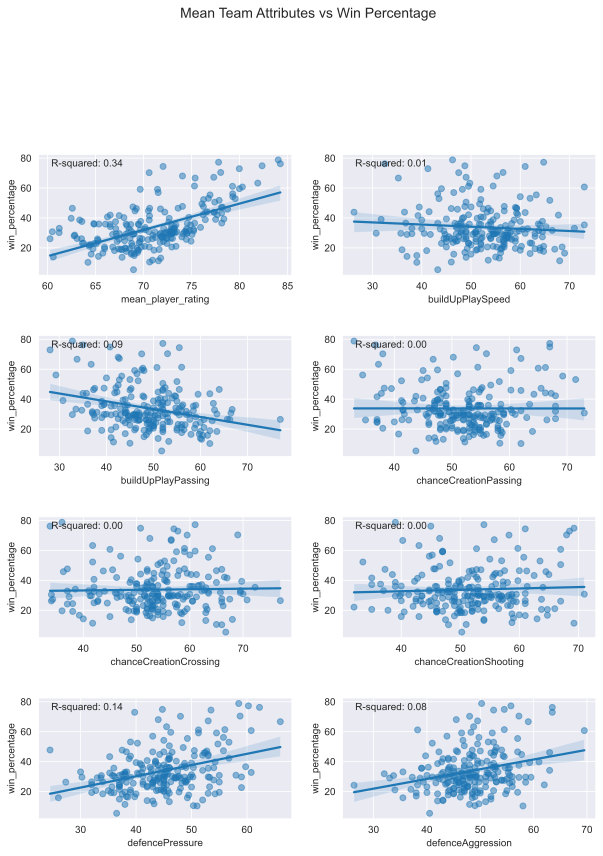

<IPython.core.display.Javascript object>

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5) 

for col, ax in zip(all_teams_attr_merged.select_dtypes('number').iloc[:,2:].columns, axes.flatten()):
    sns.regplot(x=col, y="win_percentage", data=all_teams_attr_merged, ax=ax, scatter_kws={"alpha": 0.5})
    ax.set_xlabel(col)  
    ax.set_ylabel("win_percentage")

    X = all_teams_attr_merged[col]
    y = all_teams_attr_merged["win_percentage"]
    X = sm.add_constant(X) 
    model = sm.OLS(y, X).fit()
    r_squared = model.rsquared
    ax.annotate(f'R-squared: {r_squared:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=10)

fig.suptitle("Mean Team Attributes vs Win Percentage", fontsize=14, y=1.05)

plt.show()

- When we anayze all teams, there is no strong correlation between the team attributes and the win percentage. The only attributes that have some moderate correlation are:
    - mean_player_rating
    - defence pressure
    - defence aggression
    - and some negative correlation with build-up play passing.

## 1.9. How did the top-leagues' goals-per-game ratios changed throughout the last 5 seasons? How did the top-5 teams' win percentages change throughout the last 5 seasons?

#### Main insights and observations:
- The goals-per-game ratios for top leagues didn't significantly change throughout the last 5 seasons from 2011 to 2016.
- In the span of the last 5 seasons (2011-2016), the most progressing teams were SL Benfica and FC Bayern Munich.
- Teams Real Madrid CF and Celtic got worse in win percentage.

In [65]:
seasonly_league_scores = pd.read_sql(
    """
          SELECT
                m.season,
                m.league_name,  
                SUM(m.home_team_goal) AS home_goals,
                SUM(m.away_team_goal) AS away_goals,
                SUM(m.home_team_goal + m.away_team_goal) AS total_goals,
                COUNT(m.match_api_id) AS total_matches,
                ROUND(SUM(m.home_team_goal + m.away_team_goal) * 1.0 / COUNT(m.match_api_id), 2) AS goals_per_game
           FROM long_match_info m
           WHERE m.league_name IN ('Netherlands Eredivisie',
                                   'Germany 1. Bundesliga',
                                   'Belgium Jupiler League',
                                   'Spain LIGA BBVA',
                                   'England Premier League')
           GROUP BY 1, 2
           ORDER BY 1, 2;
            """,
    conn,
)
seasonly_league_scores.head()

,season,league_name,home_goals,away_goals,total_goals,total_matches,goals_per_game
0,2011/2012,Belgium Jupiler League,366,243,609,213,2.86
1,2011/2012,England Premier League,582,450,1032,367,2.81
2,2011/2012,Germany 1. Bundesliga,508,367,875,306,2.86
3,2011/2012,Netherlands Eredivisie,535,378,913,282,3.24
4,2011/2012,Spain LIGA BBVA,633,410,1043,378,2.76


<IPython.core.display.Javascript object>

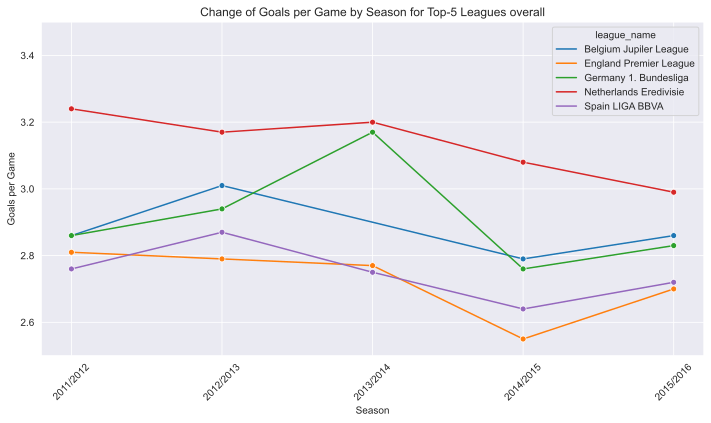

<IPython.core.display.Javascript object>

In [66]:
custom_order = ['2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']
seasonly_league_scores['season'] = pd.Categorical(seasonly_league_scores['season'], categories=custom_order, ordered=True)

# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=seasonly_league_scores, x='season', y='goals_per_game', hue='league_name', marker='o')

# Add labels and title
ax.set_xlabel('Season')
ax.set_ylabel('Goals per Game')
ax.set_title('Change of Goals per Game by Season for Top-5 Leagues overall')
ax.set_ylim(2.5, 3.5)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [67]:
pivot_leagues = seasonly_league_scores.pivot(index='league_name', columns='season', values=['goals_per_game'])
pivot_leagues['growth'] = pivot_leagues['goals_per_game', '2015/2016'] - pivot_leagues['goals_per_game', '2011/2012']
growth_leagues = pivot_leagues[['growth']].reset_index()
growth_leagues.sort_values(by=['growth'], ascending=False)

,league_name,growth
season,,
0,Belgium Jupiler League,0.00
2,Germany 1. Bundesliga,-0.03
4,Spain LIGA BBVA,-0.04
1,England Premier League,-0.11
3,Netherlands Eredivisie,-0.25


<IPython.core.display.Javascript object>

- The goals-per-game ratios for top leagues didn't significantly change throughout the last 5 seasons from 2011 to 2016.

Now, let's visualize the seasonly change in win percentages for the top-5 teams:

In [68]:
top_teams_l = wins_by_team.nlargest(5, 'win_percentage').team_name.tolist()
top_teams_wins = seasonly_team_wins[seasonly_team_wins.team_name.isin(top_teams_l)]

<IPython.core.display.Javascript object>

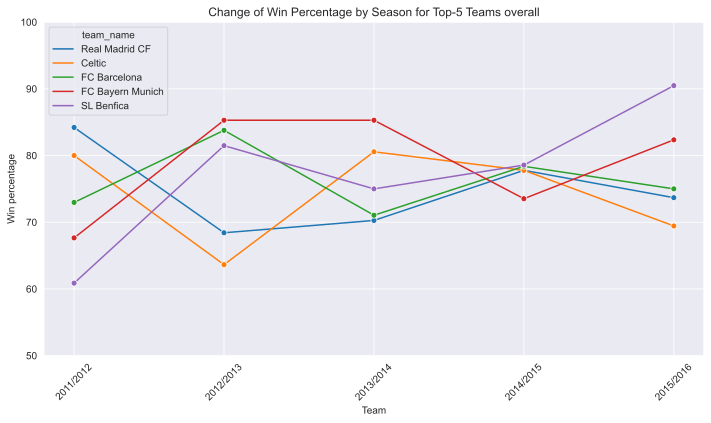

<IPython.core.display.Javascript object>

In [69]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=top_teams_wins, x='season', y='win_percentage', hue='team_name', marker='o')

ax.set_xlabel('Team')
ax.set_ylabel('Win percentage')
ax.set_title('Change of Win Percentage by Season for Top-5 Teams overall')
ax.set_ylim(50, 100)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [70]:
pivot_df = top_teams_wins.pivot(index='team_name', columns='season', values=['win_percentage'])
pivot_df['growth'] = pivot_df['win_percentage', '2015/2016'] - pivot_df['win_percentage', '2011/2012']
growth_df = pivot_df[['growth']].reset_index()
growth_df.sort_values(by=['growth'], ascending=False)

,team_name,growth
season,,
4,SL Benfica,29.61
2,FC Bayern Munich,14.70
1,FC Barcelona,2.03
3,Real Madrid CF,-10.53
0,Celtic,-10.56


<IPython.core.display.Javascript object>

- In the span of the last 5 seasons (2011-2016), the most progressing teams were SL Benfica and FC Bayern Munich. 
- Teams Real Madrid CF and Celtic got worse in win percentage.

# 2. Statistical inference 

## 2.1. Hypothesis Testing

### 2.1.1. Hypothesis 1: Mean player rating and mean team attributes are different for best and worst teams (by win percentage)

- Null Hypothesis (H0): The mean player rating/defence pressure/defence aggression is the same for both top-50 and bottom-50 teams (by win percentage).
- Alternative Hypothesis (H1): The mean player rating/defence pressure/defence aggression is different between the two groups.
- Significance level: 0.05

**Additional Notes:**
- The columns 'mean_player_rating', 'chanceCreationPassing', 'chanceCreationCrossing' don't meet the assumptions for the t-test, thus, we will use the Welch's t-test since it doesn't assume equal variances and is appropriate when variances are unequal.

In [71]:
top_teams_l = wins_by_team.nlargest(50, 'win_percentage').team_name.tolist()
bottom_teams_l = wins_by_team.nsmallest(50, 'win_percentage').team_name.tolist()

group0_data = all_teams_attr_merged[all_teams_attr_merged.team_name.isin(top_teams_l)]
group1_data = all_teams_attr_merged[all_teams_attr_merged.team_name.isin(bottom_teams_l)]

<IPython.core.display.Javascript object>

#### Testing the assumptions for the t-test

**Additional notes:**
- Shapiro-Wilk Test: This test assesses the normality of the data. The null hypothesis for this test is that the data follows a normal distribution.
- Levene's Test: This test assesses the equality of variances between the two groups. The null hypothesis for this test is that the variances are equal.
- D'Agostino and Pearson's Omnibus Test: This test is another test for normality. The null hypothesis is that the data follows a normal distribution.

In [72]:
selected_cols = all_teams_attr_merged.loc[:,'mean_player_rating':'defenceTeamWidth'].columns.tolist()

<IPython.core.display.Javascript object>

Results of the tests for assumptions for 2-sample t-tests for groups in mean_player_rating:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9609931111335754 P-value = 0.09783482551574707
Shapiro-Wilk Test - Group 2: Statistic = 0.9736695885658264 P-value = 0.3242556154727936
Levene's Test - P-value = 0.021989495776148178
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 3.6612872613313696 P-value = 0.16031035390313045
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 1.0464569856894277 P-value = 0.592604237696542
Both groups are approximately normally distributed.
--------------------------------------------------


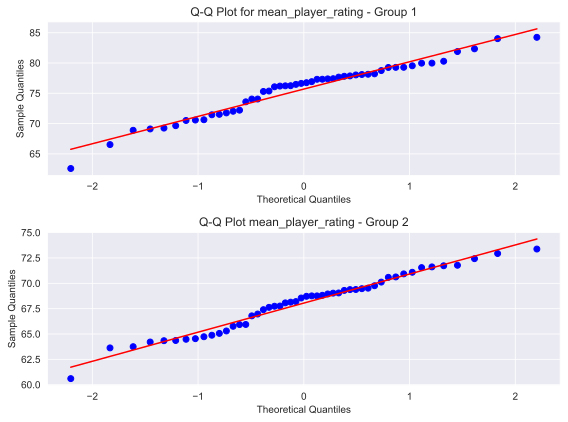

Results of the tests for assumptions for 2-sample t-tests for groups in buildUpPlaySpeed:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9894985556602478 P-value = 0.9337743520736694
Shapiro-Wilk Test - Group 2: Statistic = 0.9786611795425415 P-value = 0.4969833195209503
Levene's Test - P-value = 0.7430027138611764
Both groups pass the normality and equal variance assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 1.4292412590291201 P-value = 0.48937773205245416
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 1.1167469353351729 P-value = 0.5721389098670384
Both groups are approximately normally distributed.
--------------------------------------------------


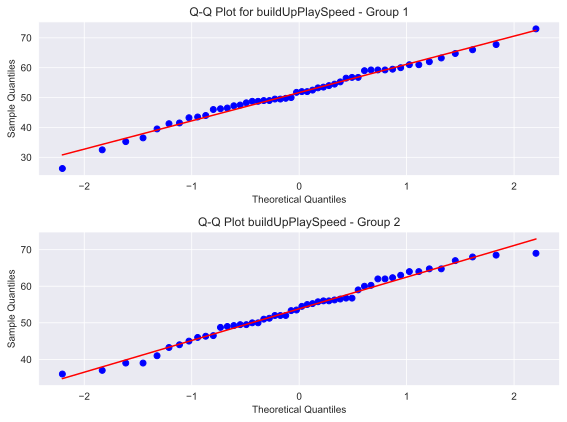

Results of the tests for assumptions for 2-sample t-tests for groups in buildUpPlayPassing:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9875870943069458 P-value = 0.8744908571243286
Shapiro-Wilk Test - Group 2: Statistic = 0.9689717292785645 P-value = 0.210133895277977
Levene's Test - P-value = 0.21002975223734727
Both groups pass the normality and equal variance assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 0.38393866677233573 P-value = 0.8253321782467917
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 2.2124288835824513 P-value = 0.3308088900523424
Both groups are approximately normally distributed.
--------------------------------------------------


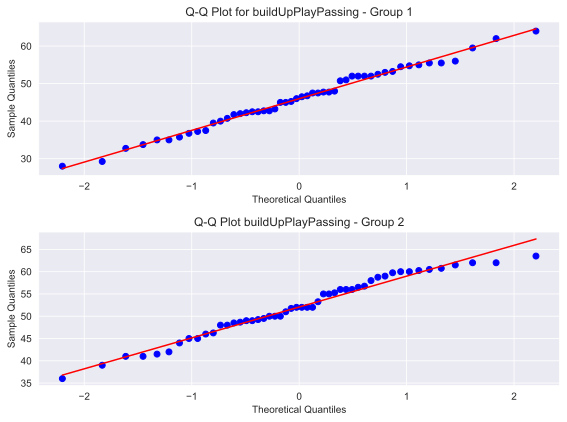

Results of the tests for assumptions for 2-sample t-tests for groups in chanceCreationPassing:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9636885523796082 P-value = 0.1268770694732666
Shapiro-Wilk Test - Group 2: Statistic = 0.9762057662010193 P-value = 0.40522849559783936
Levene's Test - P-value = 6.195103692733114e-07
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 5.683946075851655 P-value = 0.0583105035569694
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 3.732504626359585 P-value = 0.15470235273003863
Both groups are approximately normally distributed.
--------------------------------------------------


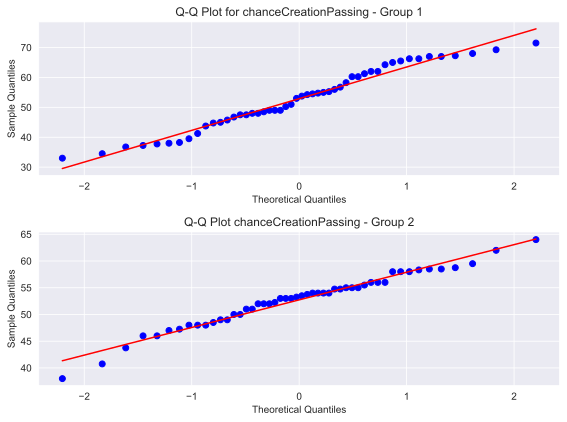

Results of the tests for assumptions for 2-sample t-tests for groups in chanceCreationCrossing:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9422423243522644 P-value = 0.0165411327034235
Shapiro-Wilk Test - Group 2: Statistic = 0.9605243802070618 P-value = 0.09350742399692535
Levene's Test - P-value = 0.42321015036597254
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 5.086021685264713 P-value = 0.07862930258222689
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 0.9258679495715598 P-value = 0.6294341896634477
Both groups are approximately normally distributed.
--------------------------------------------------


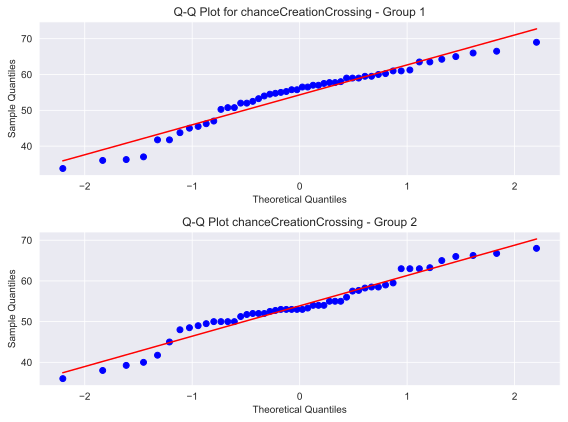

Results of the tests for assumptions for 2-sample t-tests for groups in chanceCreationShooting:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9797530174255371 P-value = 0.5415937304496765
Shapiro-Wilk Test - Group 2: Statistic = 0.9845266342163086 P-value = 0.751078188419342
Levene's Test - P-value = 0.2540077880472786
Both groups pass the normality and equal variance assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 1.620239207320551 P-value = 0.4448048627516461
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 0.07719844416105827 P-value = 0.9621362348445613
Both groups are approximately normally distributed.
--------------------------------------------------


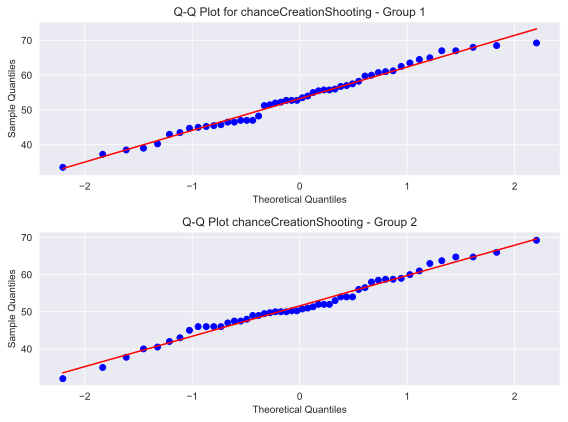

Results of the tests for assumptions for 2-sample t-tests for groups in defencePressure:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9808323383331299 P-value = 0.5875607132911682
Shapiro-Wilk Test - Group 2: Statistic = 0.9869896769523621 P-value = 0.85259610414505
Levene's Test - P-value = 0.34511641635822143
Both groups pass the normality and equal variance assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 2.732210732369542 P-value = 0.2550985427835751
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 0.2153043485648542 P-value = 0.8979398686982911
Both groups are approximately normally distributed.
--------------------------------------------------


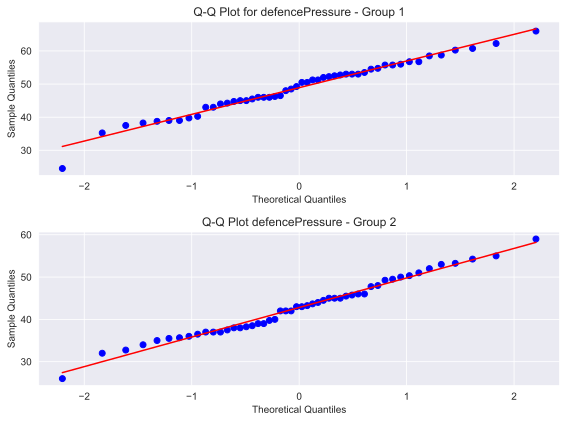

Results of the tests for assumptions for 2-sample t-tests for groups in defenceAggression:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9757957458496094 P-value = 0.39116814732551575
Shapiro-Wilk Test - Group 2: Statistic = 0.982807993888855 P-value = 0.6748201847076416
Levene's Test - P-value = 0.33573488346055813
Both groups pass the normality and equal variance assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 3.8582331426208634 P-value = 0.14527648322326975
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 0.5804456812392091 P-value = 0.748096842638773
Both groups are approximately normally distributed.
--------------------------------------------------


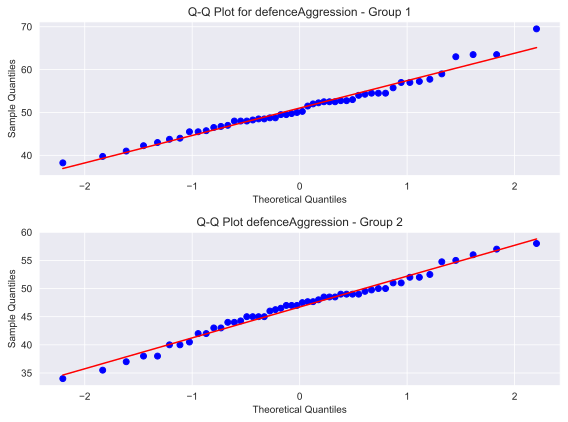

Results of the tests for assumptions for 2-sample t-tests for groups in defenceTeamWidth:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9767899513244629 P-value = 0.42589908838272095
Shapiro-Wilk Test - Group 2: Statistic = 0.9839562177658081 P-value = 0.7259731292724609
Levene's Test - P-value = 0.7892179949367862
Both groups pass the normality and equal variance assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 2.5749807059058094 P-value = 0.27596248319620376
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 0.29197725253603357 P-value = 0.8641675319386447
Both groups are approximately normally distributed.
--------------------------------------------------


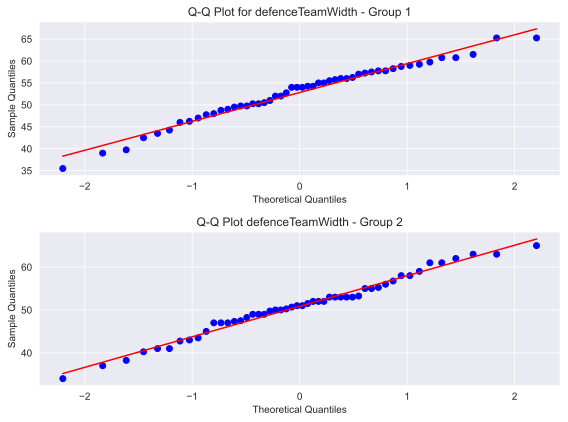

<IPython.core.display.Javascript object>

In [73]:
for col in selected_cols:
    hf.test_two_sample_ttest_assumptions(group0_data, group1_data, col)

The columns 'mean_player_rating', 'chanceCreationPassing', 'chanceCreationCrossing' don't meet the assumptions for the t-test, thus, we will use the Welch's t-test since it doesn't assume equal variances and is appropriate when variances are unequal.

#### Testing the differences using the Welch's t-test

**Conclusions:**
- The means for 'mean_player_rating' feature are significantly different between best and worst teams (by win percentage).

In [74]:
selected_features = ['mean_player_rating', 'chanceCreationPassing', 'chanceCreationCrossing']

<IPython.core.display.Javascript object>

In [75]:
for col in selected_features:
    group0 = group0_data[col].values
    group1 = group1_data[col].values
    
    t_statistic, p_value = stats.ttest_ind(group0, group1, equal_var=False)

    print("-"*50)
    print(f"Welch's t-test for the differences in {col} between top-50 and bottom-50 teams")
    print("-"*20)
    print(f"t-statistic: {t_statistic}")
    print(f"p-value: {round(p_value, 4)}")
    
    alpha = 0.05 

    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

--------------------------------------------------
Welch's t-test for the differences in mean_player_rating between top-50 and bottom-50 teams
--------------------
t-statistic: 10.18809916799714
p-value: 0.0
Reject the null hypothesis: There is a significant difference between the groups.
--------------------------------------------------
Welch's t-test for the differences in chanceCreationPassing between top-50 and bottom-50 teams
--------------------
t-statistic: 0.09622194935157323
p-value: 0.9236
Fail to reject the null hypothesis: There is no significant difference between the groups.
--------------------------------------------------
Welch's t-test for the differences in chanceCreationCrossing between top-50 and bottom-50 teams
--------------------
t-statistic: 0.27844194569673275
p-value: 0.7813
Fail to reject the null hypothesis: There is no significant difference between the groups.


<IPython.core.display.Javascript object>

#### Testing the differences in means with the t-test

**Conclusions:**
- The means of team attributes 'buildUpPlayPassing', 'defencePressure', 'defenceAggression' are significantly different between best and worst teams (by win percentage)

In [76]:
selected_features_2 = [col for col in selected_cols if col not in selected_features]

<IPython.core.display.Javascript object>

In [77]:
for col in selected_features_2:
    group0 = group0_data[col].values
    group1 = group1_data[col].values
    
    t_statistic, p_value = stats.ttest_ind(group0, group1)

    print("-"*50)
    print(f"Independent t-test for the differences in {col} between top-50 and bottom-50 teams")
    print("-"*20)
    print(f"t-statistic: {t_statistic}")
    print(f"p-value: {round(p_value, 4)}")
    
    alpha = 0.05 

    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

--------------------------------------------------
Independent t-test for the differences in buildUpPlaySpeed between top-50 and bottom-50 teams
--------------------
t-statistic: -1.216735571744985
p-value: 0.2266
Fail to reject the null hypothesis: There is no significant difference between the groups.
--------------------------------------------------
Independent t-test for the differences in buildUpPlayPassing between top-50 and bottom-50 teams
--------------------
t-statistic: -4.0090152167340944
p-value: 0.0001
Reject the null hypothesis: There is a significant difference between the groups.
--------------------------------------------------
Independent t-test for the differences in chanceCreationShooting between top-50 and bottom-50 teams
--------------------
t-statistic: 0.9738352920878226
p-value: 0.3325
Fail to reject the null hypothesis: There is no significant difference between the groups.
--------------------------------------------------
Independent t-test for the differe

<IPython.core.display.Javascript object>

### 2.1.2. Hypothesis 2: Home advantage

**Conclusions:**
- There is a statistically significant evidence that teams win more at home (aka. home advantage).

**Additional Notes:**
- Since the data doesn't meet the assumptions for a t-test, we are using the Mann-Whitney U Test.
- Mann-Whitney U Test: The Mann-Whitney U test is a non-parametric statistical test used to determine whether two independent samples come from the same population or have significantly different distributions. It's particularly useful when the assumptions of the t-test (normality and equal variances) are not met.

In [78]:
top_teams_wins = wins_by_team.nlargest(50, 'win_percentage')
bottom_teams_wins = wins_by_team.nsmallest(50, 'win_percentage')

<IPython.core.display.Javascript object>

Results of the tests for assumptions for 2-sample t-tests for groups in home_wins:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9794473052024841 P-value = 0.5288934111595154
Shapiro-Wilk Test - Group 2: Statistic = 0.8894866704940796 P-value = 0.0002199562732130289
Levene's Test - P-value = 2.929457830392284e-06
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 0.8159001560821111 P-value = 0.6650120766993339
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 6.102257144896653 P-value = 0.04730550656250528
One or both groups may not be normally distributed.
--------------------------------------------------


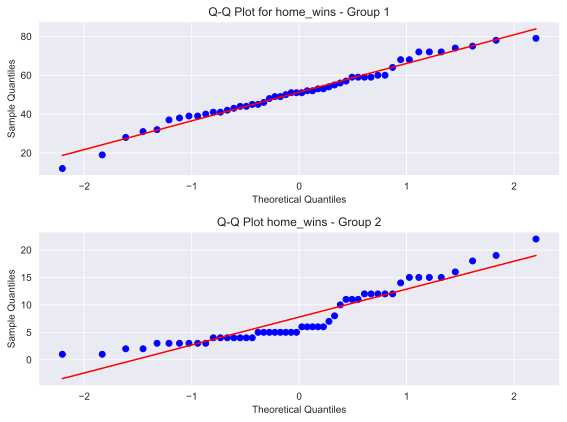

Results of the tests for assumptions for 2-sample t-tests for groups in away_wins:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9731517434120178 P-value = 0.3094637393951416
Shapiro-Wilk Test - Group 2: Statistic = 0.7786139249801636 P-value = 2.917551569225907e-07
Levene's Test - P-value = 2.2615670564039355e-09
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 1.0467470273670394 P-value = 0.5925183039641528
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 43.54960617395581 P-value = 3.494002205590602e-10
One or both groups may not be normally distributed.
--------------------------------------------------


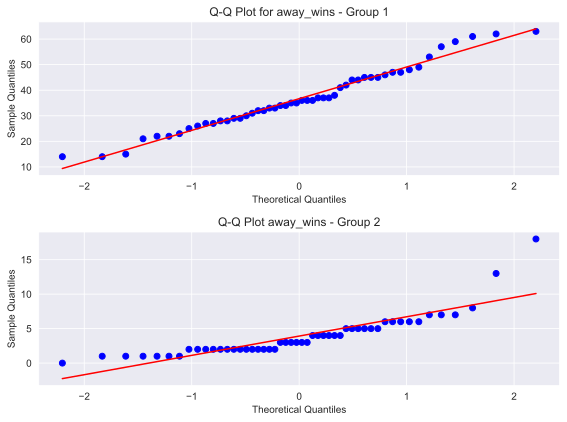

<IPython.core.display.Javascript object>

In [79]:
for col in ['home_wins', 'away_wins']:
    hf.test_two_sample_ttest_assumptions(top_teams_wins, bottom_teams_wins, col)

In [80]:
home_wins_series = top_teams_wins['home_wins']
away_wins_series = top_teams_wins['away_wins']

statistic, p_value = mannwhitneyu(home_wins_series, away_wins_series, alternative='two-sided')

print("-"*50)
print(f" Mann-Whitney U test for the differences in home wins and away wins in the top-50 teams")
print("-"*20)
print(f"Mann-Whitney statistic: {t_statistic}")
print(f"p-value: {round(p_value, 4)}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")

--------------------------------------------------
 Mann-Whitney U test for the differences in home wins and away wins in the top-50 teams
--------------------
Mann-Whitney statistic: 1.447172248661631
p-value: 0.0
Reject the null hypothesis: There is a significant difference.


<IPython.core.display.Javascript object>

In [81]:
home_wins_series = bottom_teams_wins['home_wins']
away_wins_series = bottom_teams_wins['away_wins']

statistic, p_value = mannwhitneyu(home_wins_series, away_wins_series, alternative='two-sided')

print("-"*50)
print(f" Mann-Whitney U test for the differences in home wins and away wins in the bottom-50 teams")
print("-"*20)
print(f"Mann-Whitney statistic: {t_statistic}")
print(f"p-value: {round(p_value, 4)}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")

--------------------------------------------------
 Mann-Whitney U test for the differences in home wins and away wins in the bottom-50 teams
--------------------
Mann-Whitney statistic: 1.447172248661631
p-value: 0.0
Reject the null hypothesis: There is a significant difference.


<IPython.core.display.Javascript object>

In [82]:
print("Medians in top teams for:")
print("Home wins - ", top_teams_wins['home_wins'].median())
print("Away wins - ", top_teams_wins['away_wins'].median())

Medians in top teams for:
Home wins -  51.0
Away wins -  35.5


<IPython.core.display.Javascript object>

In [83]:
print("Medians in bottom teams for:")
print("Home wins - ", bottom_teams_wins['home_wins'].median())
print("Away wins - ", bottom_teams_wins['away_wins'].median())

Medians in bottom teams for:
Home wins -  5.5
Away wins -  3.0


<IPython.core.display.Javascript object>

## 2.2. Confidence intervals

**Conclusions:**
- Confidence intervals for top teams are:
    -  mean player rating: 74.45 - 76.94
    -  build-up play passing: 43.69 - 48.27
    -  defence pressure: 46.71 - 51.11
    -  defence aggression: 49.28 - 52.78

Teams with these attributes have higher percentage of winning. We can use this information when creating betting odds.

In [87]:
significant_columns = ['mean_player_rating', 'buildUpPlayPassing', 'defencePressure', 'defenceAggression']

<IPython.core.display.Javascript object>

In [89]:
for col in significant_columns:
    print(f"95% confidence interval for {col} content for best teams:")
    print(sm.stats.DescrStatsW(group0_data[col]).zconfint_mean())
    print("")
    print(f"95% confidence interval for {col} content for worst teams:")
    print(sm.stats.DescrStatsW(group1_data[col]).zconfint_mean())  
    print("")
    print("-"*50)

95% confidence interval for mean_player_rating content for best teams:
(74.4493773945032, 76.93742260549682)

95% confidence interval for mean_player_rating content for worst teams:
(67.26498287662719, 68.83341712337281)

--------------------------------------------------
95% confidence interval for buildUpPlayPassing content for best teams:
(43.69496514749553, 48.27503485250447)

95% confidence interval for buildUpPlayPassing content for worst teams:
(50.16957201043755, 53.95709465622912)

--------------------------------------------------
95% confidence interval for defencePressure content for best teams:
(46.707196643089596, 51.1128033569104)

95% confidence interval for defencePressure content for worst teams:
(40.90891308046922, 44.70775358619744)

--------------------------------------------------
95% confidence interval for defenceAggression content for best teams:
(49.27859693158995, 52.78140306841005)

95% confidence interval for defenceAggression content for worst teams:
(45.

<IPython.core.display.Javascript object>

# 3. Fitting models to data and feature selection

## 3.1. Regression

### 3.1.1. Regression with team attributes and mean players' overall rating

#### Main insights and observations:
- Approximately 42% of the variance in "win_percentage" is explained by the independent variables (for a linear regression with all features).
- Approximately 40% of the variance in "win_percentage" is explained by the independent variables (for a linear regression with reduced features).
- The most significant features are: 'mean_player_rating' and 'defencePressure'. Also, the feature 'defenceAggression' is moderately significant.
- Linear Regression model appears to perform better than the Random Forest Regressor and Gradient Boosting Regressor (based on R-squared, MSE, and MAE).

In [84]:
all_teams_attr_merged.head()

,team_name,goals_per_game,win_percentage,mean_player_rating,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,Beerschot AC,1.26,26.00,65.20,51.00,47.00,42.50,55.00,49.00,45.00,46.00,58.50
1,Club Brugge KV,2.08,59.13,69.65,48.25,48.00,45.00,59.00,47.00,51.25,52.25,52.75
2,KAA Gent,1.69,47.37,68.89,50.00,39.50,38.25,66.00,37.25,50.50,52.75,49.00
3,KRC Genk,1.67,44.74,70.51,56.75,42.25,54.75,53.25,56.00,44.25,48.00,58.75
4,KSV Cercle Brugge,0.95,22.62,65.06,56.75,45.00,53.50,63.00,42.00,59.00,47.00,62.00


<IPython.core.display.Javascript object>

In [212]:
X = all_teams_attr_merged.drop(['win_percentage', 'goals_per_game', 'team_name'], axis=1)  
y = all_teams_attr_merged['win_percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<IPython.core.display.Javascript object>

In [213]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

y_pred_train = model.predict(X_train)

mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("-"*50)
print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
print(f"Mean Squared Error (MSE): {round(mse, 2)}")
print(f"R-squared (R^2): {round(r2, 2)}")

                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     13.27
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           7.21e-16
Time:                        23:05:02   Log-Likelihood:                -663.15
No. Observations:                 176   AIC:                             1346.
Df Residuals:                     166   BIC:                             1378.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -85

<IPython.core.display.Javascript object>

- Approximately 41.2% of the variance in "win_percentage" is explained by the independent variables.
- The most significant features are: 'mean_player_rating' and 'defencePressure'. Also, the feature 'defenceAggression' is moderately significant.

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train, y_train)

gb_reg_predictions = gb_reg.predict(X_test)

mae_gb = mean_absolute_error(y_test, gb_reg_predictions)
mse_gb = mean_squared_error(y_test, gb_reg_predictions)
r2_gb = r2_score(y_test, gb_reg_predictions)

print(f"Gradient Boosting Regressor with all features:")
print(f"Mean Absolute Error (MAE): {round(mae_gb, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_gb, 2)}")
print(f"R-squared (R^2): {round(r2_gb, 2)}")

Gradient Boosting Regressor with all features:
Mean Absolute Error (MAE): 10.34
Mean Squared Error (MSE): 180.38
R-squared (R^2): 0.26


<IPython.core.display.Javascript object>

Most important features:
 mean_player_rating        0.503574
defencePressure           0.118712
chanceCreationCrossing    0.064842
defenceTeamWidth          0.064372
defenceAggression         0.057516
dtype: float64
----------------------------------------------------------------------------------------------------
Random Forest Regressor with all features:
Mean Absolute Error (MAE): 10.14
Mean Squared Error (MSE): 179.58
R-squared (R^2): 0.27


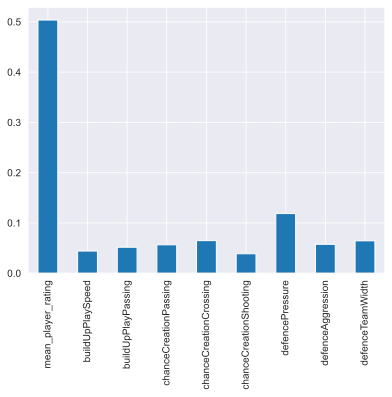

<IPython.core.display.Javascript object>

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)


importances = rf_reg.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.plot.bar()

print("Most important features:\n", importances.nlargest(5))
print("-"*100)

rf_reg_predictions = rf_reg.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_reg_predictions)
mse_rf = mean_squared_error(y_test, rf_reg_predictions)
r2_rf = r2_score(y_test, rf_reg_predictions)

print(f"Random Forest Regressor with all features:")
print(f"Mean Absolute Error (MAE): {round(mae_rf, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_rf, 2)}")
print(f"R-squared (R^2): {round(r2_rf, 2)}")

Based on the outputs above, not all features are significant. We will try to train models with reduced number of features.

In [224]:
X_reduced = all_teams_attr_merged[['mean_player_rating', 'defencePressure', 'defenceAggression']]
y_reduced = all_teams_attr_merged['win_percentage']

<IPython.core.display.Javascript object>

In [225]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, 
                                                                                    y_reduced, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42)

X_train_reduced = sm.add_constant(X_train_reduced)
model = sm.OLS(y_train_reduced, X_train_reduced).fit()

y_pred_train_reduced = model.predict(X_train_reduced)

mae = mean_absolute_error(y_train_reduced, y_pred_train_reduced)
mse = mean_squared_error(y_train_reduced, y_pred_train_reduced)
r2 = r2_score(y_train_reduced, y_pred_train_reduced)

print(f"Linear Regression with reduced features:")
print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
print(f"Mean Squared Error (MSE): {round(mse, 2)}")
print(f"R-squared (R^2): {round(r2, 2)}")

Linear Regression with reduced features:
Mean Absolute Error (MAE): 8.29
Mean Squared Error (MSE): 113.35
R-squared (R^2): 0.4


<IPython.core.display.Javascript object>

In [226]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, 
                                                                                    y_reduced, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_reduced, y_train_reduced)

rf_reg_predictions = rf_reg.predict(X_test_reduced)

mae_rf = mean_absolute_error(y_test_reduced, rf_reg_predictions)
mse_rf = mean_squared_error(y_test_reduced, rf_reg_predictions)
r2_rf = r2_score(y_test_reduced, rf_reg_predictions)

print(f"Random Forest Regressor with reduced features:")
print(f"Mean Absolute Error (MAE): {round(mae_rf, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_rf, 2)}")
print(f"R-squared (R^2): {round(r2_rf, 2)}")

Random Forest Regressor with reduced features:
Mean Absolute Error (MAE): 9.79
Mean Squared Error (MSE): 176.24
R-squared (R^2): 0.28


<IPython.core.display.Javascript object>

In [227]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, 
                                                                                    y_reduced, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42)

gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train_reduced, y_train_reduced)

gb_reg_predictions = gb_reg.predict(X_test_reduced)

mae_gb = mean_absolute_error(y_test_reduced, gb_reg_predictions)
mse_gb = mean_squared_error(y_test_reduced, gb_reg_predictions)
r2_gb = r2_score(y_test_reduced, gb_reg_predictions)

print(f"Gradient Boosting Regressor with reduced features:")
print(f"Mean Absolute Error (MAE): {round(mae_gb, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_gb, 2)}")
print(f"R-squared (R^2): {round(r2_gb, 2)}")

Gradient Boosting Regressor with reduced features:
Mean Absolute Error (MAE): 10.4
Mean Squared Error (MSE): 199.3
R-squared (R^2): 0.19


<IPython.core.display.Javascript object>

- Linear Regression model appears to perform better than the Random Forest Regressor and Gradient Boosting Regressor (based on R-squared, MSE, and MAE).

### 3.1.2. Regression with mean player attributes and reduced team attributes 

#### Main insights and observations:
- Approximately 50% of the variance in "win_percentage" is explained by the independent variables (for a linear regression with team attributes and mean players' attributes).
The most significant features for predicting the win percentage are: 'defencePressure', 'avg_stamina', 'defenceAggression'. Also some significance have features 'avg_passing', 'mean_player_rating', 'avg_strength', and 'avg_shooting'.
- Linear regression with the reduced features shows that approximately 28% of the variance in "win_percentage" is explained by the independent variables.

In [228]:
player_attr = pd.read_sql(
    """
    SELECT p.player_api_id,
           p.player_name,
           ROUND(AVG(p.overall_rating), 2) AS avg_overall_rating,
           ROUND(AVG(p.bmi), 2) AS avg_bmi,
           ROUND(AVG(p.heading_accuracy), 2) AS avg_heading_accuracy,
           ROUND(AVG(p.sprint_speed), 2) AS avg_sprint_speed,
           ROUND(AVG(p.balance), 2) AS avg_balance,
           ROUND(AVG(p.jumping), 2) AS avg_jumping,
           ROUND(AVG(p.stamina), 2) AS avg_stamina,
           ROUND(AVG(p.strength), 2) AS avg_strength,
           ROUND(AVG(p.gk_diving), 2) AS avg_gk_diving,
           ROUND(AVG(p.passing), 2) AS avg_passing,
           ROUND(AVG(p.shooting), 2) AS avg_shooting,
           ROUND(AVG(p.defending), 2) AS avg_defending,
           ROUND(AVG(p.goalkeeping), 2) AS avg_goalkeeping
    FROM player_info p
    GROUP BY player_name
    ORDER BY avg_overall_rating DESC
""", 
conn
)
player_attr.head()

,player_api_id,player_name,avg_overall_rating,avg_bmi,avg_heading_accuracy,avg_sprint_speed,avg_balance,avg_jumping,avg_stamina,avg_strength,avg_gk_diving,avg_passing,avg_shooting,avg_defending,avg_goalkeeping
0,30981,Lionel Messi,93.80,24.90,71.25,90.25,95.0,72.0,78.37,58.50,6.0,84.10,87.63,19.80,12.00
1,30893,Cristiano Ronaldo,92.20,23.22,86.32,93.80,69.8,94.0,88.32,79.00,7.0,81.30,93.00,25.33,12.75
2,30955,Andres Iniesta,89.40,23.49,54.00,74.50,86.1,54.0,75.60,59.00,6.0,86.58,71.03,56.67,9.75
3,39854,Xavi Hernandez,89.00,23.18,51.00,65.25,90.0,53.0,70.88,60.25,5.0,89.48,71.29,59.00,10.25
4,35724,Zlatan Ibrahimovic,88.88,24.78,75.70,77.50,38.0,75.3,78.10,92.30,13.0,79.15,89.93,30.07,11.50


<IPython.core.display.Javascript object>

In [229]:
player_attr_full = pd.merge(all_players, player_attr, on='player_api_id')
player_attr_full.drop(columns=['league_name', 'player_api_id', 'player_name'], inplace=True)

<IPython.core.display.Javascript object>

In [230]:
mean_rating_by_team = player_attr_full.groupby('team_name')\
                                      .apply(lambda x: round(x.mean(), 2)).reset_index()\
                                      .sort_values(by='avg_overall_rating', ascending=False)\
                                      .rename(columns={'avg_overall_rating': 'mean_player_rating'})
mean_rating_by_team.head()

,team_name,mean_player_rating,avg_bmi,avg_heading_accuracy,avg_sprint_speed,avg_balance,avg_jumping,avg_stamina,avg_strength,avg_gk_diving,avg_passing,avg_shooting,avg_defending,avg_goalkeeping
61,FC Barcelona,84.24,22.89,63.03,72.16,72.12,71.20,73.35,68.23,12.92,71.84,63.79,58.93,15.92
62,FC Bayern Munich,84.02,23.66,63.93,73.94,68.98,69.13,72.56,72.84,16.66,72.15,67.24,54.30,16.40
154,Real Madrid CF,82.34,23.02,68.27,72.46,64.59,71.18,69.80,73.41,14.69,67.83,63.37,57.74,14.83
116,Manchester City,81.89,23.44,67.89,71.51,66.39,72.21,73.90,75.47,14.64,69.74,65.45,59.46,14.53
26,Borussia Dortmund,80.29,23.31,63.69,74.75,67.60,69.92,75.00,70.57,18.44,65.28,62.63,56.38,15.28


<IPython.core.display.Javascript object>

In [231]:
reduced_team_attr = all_teams_attr_merged[['team_name', 'win_percentage', 
                                           'defencePressure', 
                                           'defenceAggression']]

<IPython.core.display.Javascript object>

In [232]:
all_teams_player_attr = pd.merge(reduced_team_attr, mean_rating_by_team, on=['team_name'])
all_teams_player_attr.head()

,team_name,win_percentage,defencePressure,defenceAggression,mean_player_rating,avg_bmi,avg_heading_accuracy,avg_sprint_speed,avg_balance,avg_jumping,avg_stamina,avg_strength,avg_gk_diving,avg_passing,avg_shooting,avg_defending,avg_goalkeeping
0,Beerschot AC,26.00,45.00,46.00,65.20,23.20,52.80,62.43,62.07,64.69,64.01,68.07,17.40,54.24,50.13,47.23,17.21
1,Club Brugge KV,59.13,51.25,52.25,69.65,23.35,54.35,68.76,66.18,72.45,70.81,68.17,13.96,58.68,56.92,48.51,13.95
2,KAA Gent,47.37,50.50,52.75,68.89,23.46,59.60,63.74,58.18,69.02,65.67,73.42,17.53,55.52,53.26,46.80,17.74
3,KRC Genk,44.74,44.25,48.00,70.51,23.34,59.81,65.27,61.81,68.07,69.51,71.81,15.39,60.33,56.83,52.20,15.27
4,KSV Cercle Brugge,22.62,59.00,47.00,65.06,22.89,52.64,61.37,64.59,60.62,61.24,64.97,13.75,56.44,54.66,47.32,15.43


<IPython.core.display.Javascript object>

In [233]:
X = all_teams_player_attr.drop(['win_percentage', 'team_name'], axis=1)  
y = all_teams_player_attr['win_percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<IPython.core.display.Javascript object>

In [236]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

y_pred_train = model.predict(X_train)

mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("-"*50)
print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
print(f"Mean Squared Error (MSE): {round(mse, 2)}")
print(f"R-squared (R^2): {round(r2, 2)}")

                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     10.65
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           1.78e-17
Time:                        23:11:48   Log-Likelihood:                -649.92
No. Observations:                 176   AIC:                             1332.
Df Residuals:                     160   BIC:                             1383.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -87.3726 

<IPython.core.display.Javascript object>

Most important features:
 mean_player_rating    0.413066
avg_passing           0.094661
avg_strength          0.073784
defencePressure       0.061707
avg_shooting          0.059723
dtype: float64
----------------------------------------------------------------------------------------------------
Random Forest Regressor:
Mean Absolute Error (MAE): 9.258513636363633
Mean Squared Error (MSE): 139.25319083727265
R-squared (R^2): 0.4312687122468666


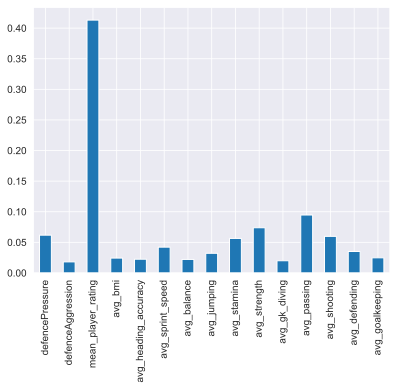

<IPython.core.display.Javascript object>

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)


importances = rf_reg.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.plot.bar()

print("Most important features:\n", importances.nlargest(5))
print("-"*100)

rf_reg_predictions = rf_reg.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_reg_predictions)
mse_rf = mean_squared_error(y_test, rf_reg_predictions)
r2_rf = r2_score(y_test, rf_reg_predictions)

print(f"Random Forest Regressor:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R^2): {r2_rf}")

- Approximately 50% of the variance in "win_percentage" is explained by the independent variables (for a linear regression with team attributes and mean players' attributes).
- The most significant features for predicting the win percentage are: 'defencePressure', 'avg_stamina', 'defenceAggression'. Also some significance have features 'avg_passing', 'mean_player_rating', 'avg_strength', and 'avg_shooting'.

In [241]:
X_reduced = X[['defencePressure', 'avg_stamina', 'defenceAggression',
                'avg_passing', 'mean_player_rating', 'avg_strength',
                'avg_shooting']]
y_reduced = all_teams_player_attr['win_percentage']

<IPython.core.display.Javascript object>

In [242]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, 
                                                                                    y_reduced, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42)

<IPython.core.display.Javascript object>

In [243]:
X_train = sm.add_constant(X_train_reduced)
model = sm.OLS(y_train_reduced, X_train_reduced).fit()
print(model.summary())

y_pred_train = model.predict(X_train_reduced)

mae = mean_absolute_error(y_train_reduced, y_pred_train)
mse = mean_squared_error(y_train_reduced, y_pred_train)
r2 = r2_score(y_train_reduced, y_pred_train)

print("-"*50)
print(f"Linear Regression with reduced features:")
print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
print(f"Mean Squared Error (MSE): {round(mse, 2)}")
print(f"R-squared (R^2): {round(r2, 2)}")

                                 OLS Regression Results                                
Dep. Variable:         win_percentage   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                              208.8
Date:                Mon, 11 Sep 2023   Prob (F-statistic):                    1.02e-79
Time:                        23:29:15   Log-Likelihood:                         -681.14
No. Observations:                 176   AIC:                                      1376.
Df Residuals:                     169   BIC:                                      1398.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

<IPython.core.display.Javascript object>

- Linear regression with the reduced features shows that approximately 29% of the variance in "win_percentage" is explained by the independent variables.

## 3.2. Classification

#### Main insights and observations:
- When predicting the outcome of the match(home/away team or draw) with mean team'/players' attributes, Support Vector Classifier performs best compared to RandomForestClassifier and XGBClassifier (by accuracy and F1 score). Though, the accuracy and F1 scores are not very high for all models. The models need further improvement.
- Based on the result of RandomForestClassifier, the most significant features to predict a match outcome, are (both for home and away teams):
    - win_percentage
    - mean_player_rating
    - avg_passing
    - avg_shooting
    - avg_sprint_speed

In [244]:
all_teams_player_attr

,team_name,win_percentage,defencePressure,defenceAggression,mean_player_rating,avg_bmi,avg_heading_accuracy,avg_sprint_speed,avg_balance,avg_jumping,avg_stamina,avg_strength,avg_gk_diving,avg_passing,avg_shooting,avg_defending,avg_goalkeeping
0,Beerschot AC,26.00,45.00,46.00,65.20,23.20,52.80,62.43,62.07,64.69,64.01,68.07,17.40,54.24,50.13,47.23,17.21
1,Club Brugge KV,59.13,51.25,52.25,69.65,23.35,54.35,68.76,66.18,72.45,70.81,68.17,13.96,58.68,56.92,48.51,13.95
2,KAA Gent,47.37,50.50,52.75,68.89,23.46,59.60,63.74,58.18,69.02,65.67,73.42,17.53,55.52,53.26,46.80,17.74
3,KRC Genk,44.74,44.25,48.00,70.51,23.34,59.81,65.27,61.81,68.07,69.51,71.81,15.39,60.33,56.83,52.20,15.27
4,KSV Cercle Brugge,22.62,59.00,47.00,65.06,22.89,52.64,61.37,64.59,60.62,61.24,64.97,13.75,56.44,54.66,47.32,15.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Sevilla FC,43.62,39.00,48.75,77.38,23.32,64.43,71.57,67.03,71.77,70.60,70.42,14.52,63.72,60.26,53.26,13.58
216,UD Almería,26.39,37.00,53.00,69.61,23.09,50.88,67.25,65.32,65.23,72.98,70.71,13.81,56.35,53.33,47.55,15.01
217,UD Las Palmas,35.48,53.00,39.00,69.50,22.68,48.44,68.91,68.80,70.77,72.20,66.73,20.44,53.65,47.60,50.45,19.35
218,Valencia CF,43.85,50.50,39.75,77.32,23.52,60.26,68.53,68.68,70.83,68.13,68.54,18.82,62.52,60.08,55.21,17.35


<IPython.core.display.Javascript object>

We will query the matches' outcomes encoded as home(or 1), away(or 2), draw(or 0):

In [297]:
matches_wins = pd.read_sql("""
    SELECT lmi.match_api_id,
           lmi.home_team_name,
           lmi.away_team_name,
           CASE
               WHEN lmi.match_winner = lmi.home_team_name 
                   THEN 'home'
               WHEN lmi.match_winner = lmi.away_team_name 
                   THEN 'away'
               ELSE 'draw'
            END AS winner,
           CASE
               WHEN lmi.match_winner = lmi.home_team_name 
                   THEN 1
               WHEN lmi.match_winner = lmi.away_team_name 
                   THEN 2
               ELSE 0
            END AS winner_encoded
    FROM long_match_info lmi
""", conn)
matches_wins.head()

,match_api_id,home_team_name,away_team_name,winner,winner_encoded
0,1032692,Oud-Heverlee Leuven,RSC Anderlecht,home,1
1,1032693,RAEC Mons,Standard de Liège,draw,0
2,1032694,KRC Genk,Beerschot AC,home,1
3,1032697,KV Kortrijk,Lierse SK,draw,0
4,1032698,KV Mechelen,Sint-Truidense VV,home,1


<IPython.core.display.Javascript object>

In [298]:
matches_wins_short = matches_wins.drop(columns=['winner'])

<IPython.core.display.Javascript object>

In [299]:
home_team_attributes = matches_wins_short.merge(all_teams_player_attr, left_on='home_team_name', right_on='team_name')

columns_to_prefix = all_teams_player_attr.columns[1:]
for column in columns_to_prefix:
    home_team_attributes.rename(columns={column: f"home_{column}"}, inplace=True)

home_team_attributes.drop(columns=['team_name'], inplace=True)

away_team_attributes = matches_wins_short.merge(all_teams_player_attr, 
                                          left_on='away_team_name', 
                                          right_on='team_name')
for column in columns_to_prefix:
    away_team_attributes.rename(columns={column: f"away_{column}"}, inplace=True)

away_team_attributes.drop(columns=['team_name'], inplace=True)

<IPython.core.display.Javascript object>

In [300]:
home_team_attributes

,match_api_id,home_team_name,away_team_name,winner_encoded,home_win_percentage,home_defencePressure,home_defenceAggression,home_mean_player_rating,home_avg_bmi,home_avg_heading_accuracy,home_avg_sprint_speed,home_avg_balance,home_avg_jumping,home_avg_stamina,home_avg_strength,home_avg_gk_diving,home_avg_passing,home_avg_shooting,home_avg_defending,home_avg_goalkeeping
0,1032692,Oud-Heverlee Leuven,RSC Anderlecht,1,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,65.78,66.32,15.87,53.64,53.0,46.87,13.52
1,1032719,Oud-Heverlee Leuven,KV Mechelen,2,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,65.78,66.32,15.87,53.64,53.0,46.87,13.52
2,1032736,Oud-Heverlee Leuven,RAEC Mons,1,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,65.78,66.32,15.87,53.64,53.0,46.87,13.52
3,1032753,Oud-Heverlee Leuven,KRC Genk,0,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,65.78,66.32,15.87,53.64,53.0,46.87,13.52
4,1032768,Oud-Heverlee Leuven,KVC Westerlo,0,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,65.78,66.32,15.87,53.64,53.0,46.87,13.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12980,2030441,UD Las Palmas,Real Madrid CF,2,35.48,53.0,39.0,69.50,22.68,48.44,68.91,68.80,70.77,72.20,66.73,20.44,53.65,47.6,50.45,19.35
12981,2030462,UD Las Palmas,Valencia CF,1,35.48,53.0,39.0,69.50,22.68,48.44,68.91,68.80,70.77,72.20,66.73,20.44,53.65,47.6,50.45,19.35
12982,2030483,UD Las Palmas,Real Sporting de Gijón,0,35.48,53.0,39.0,69.50,22.68,48.44,68.91,68.80,70.77,72.20,66.73,20.44,53.65,47.6,50.45,19.35
12983,2030504,UD Las Palmas,RCD Espanyol,1,35.48,53.0,39.0,69.50,22.68,48.44,68.91,68.80,70.77,72.20,66.73,20.44,53.65,47.6,50.45,19.35


<IPython.core.display.Javascript object>

In [301]:
merged_attributes = home_team_attributes.merge(away_team_attributes, on='match_api_id')
merged_attributes = merged_attributes.drop(columns=['winner_encoded_x', 'home_team_name_x', 'away_team_name_x'])
merged_attributes.rename(columns={'winner_encoded_y': 'winner_encoded', 
                                  'home_team_name_y': 'home_team_name',
                                  'away_team_name_y': 'away_team_name'}, inplace=True)
merged_attributes.head()

,match_api_id,home_win_percentage,home_defencePressure,home_defenceAggression,home_mean_player_rating,home_avg_bmi,home_avg_heading_accuracy,home_avg_sprint_speed,home_avg_balance,home_avg_jumping,...,away_avg_sprint_speed,away_avg_balance,away_avg_jumping,away_avg_stamina,away_avg_strength,away_avg_gk_diving,away_avg_passing,away_avg_shooting,away_avg_defending,away_avg_goalkeeping
0,1032692,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,...,72.47,62.27,70.94,70.71,69.43,15.43,61.40,59.45,48.97,14.76
1,1032719,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,...,66.97,66.88,66.27,70.30,66.89,10.53,57.76,55.25,49.88,10.35
2,1032736,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,...,61.77,64.47,67.83,64.73,66.52,14.98,55.30,55.28,44.71,14.56
3,1032753,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,...,65.27,61.81,68.07,69.51,71.81,15.39,60.33,56.83,52.20,15.27
4,1032768,26.09,43.0,44.0,63.54,22.82,53.53,60.79,63.52,61.95,...,63.82,64.28,63.14,64.58,66.15,15.86,52.17,51.60,46.73,16.98


<IPython.core.display.Javascript object>

In [312]:
X = merged_attributes.drop(['winner_encoded', 'match_api_id', 'home_team_name', 'away_team_name'], axis=1)
y = merged_attributes['winner_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  

<IPython.core.display.Javascript object>

In [309]:
svm = SVC()
xgb = XGBClassifier() 
rf = RandomForestClassifier()

models = [rf, svm, xgb]

for model in models:

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(model)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))


scores = cross_val_score(rf, X, y, cv=5, scoring='f1_macro')
print("Cross-validated F1 for Random Forest:", scores.mean())

scores = cross_val_score(svm, X, y, cv=5, scoring='f1_macro')
print("Cross-validated F1 for SVM:", scores.mean())

scores = cross_val_score(xgb, X, y, cv=5, scoring='f1_macro')  
print("Cross-validated F1:", scores.mean())

RandomForestClassifier()
[[126 343 189]
 [215 742 228]
 [162 288 300]]
              precision    recall  f1-score   support

           0       0.25      0.19      0.22       658
           1       0.54      0.63      0.58      1185
           2       0.42      0.40      0.41       750

    accuracy                           0.45      2593
   macro avg       0.40      0.41      0.40      2593
weighted avg       0.43      0.45      0.44      2593

SVC()
[[   0  501  157]
 [   0 1043  142]
 [   0  414  336]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       658
           1       0.53      0.88      0.66      1185
           2       0.53      0.45      0.49       750

    accuracy                           0.53      2593
   macro avg       0.35      0.44      0.38      2593
weighted avg       0.40      0.53      0.44      2593

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsamp

<IPython.core.display.Javascript object>

- RandomForestClassifier:
    - Accuracy: 46%
    - Macro-Average F1-Score: 0.42
    - Weighted-Average F1-Score: 0.45
    - Cross-Validated Accuracy: 44.3%

- SVC (Support Vector Classifier):
    - Accuracy: 53%
    - Macro-Average F1-Score: 0.38
    - Weighted-Average F1-Score: 0.44
    - Cross-Validated Accuracy: 52.0%

- XGBClassifier (XGBoost Classifier):
    - Accuracy: 47%
    - Macro-Average F1-Score: 0.41
    - Weighted-Average F1-Score: 0.45
    - Cross-Validated F1-Score: 35.3%

- Support Vector Classifier performs best compared to RandomForestClassifier and XGBClassifier (by accuracy and F1 score)

home_win_percentage: 0.06518329266551434
away_win_percentage: 0.059328528980048326
away_mean_player_rating: 0.03915465153918858
home_mean_player_rating: 0.03818462753079749
home_avg_passing: 0.03700099702695983
away_avg_passing: 0.034445479557062814
home_avg_shooting: 0.03320618078296461
away_avg_shooting: 0.0314539655702228
away_avg_sprint_speed: 0.031282319547008074
home_avg_sprint_speed: 0.030818091470120646


<Axes: >

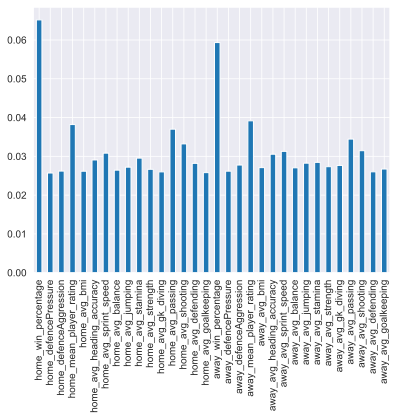

<IPython.core.display.Javascript object>

In [311]:
importances = rf.feature_importances_
feature_names = X_train.columns  

feature_importance_tuples = list(zip(feature_names, importances))
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)
top_n_features = feature_importance_tuples[:10]

for feature, importance in top_n_features:
    print(f"{feature}: {importance}")

importances = pd.Series(importances, index=X_train.columns)
importances.plot.bar()

Based on the result of RandomForestClassifier, the most significant features to predict a match outcome, are (both for home and away teams):
- win_percentage
- mean_player_rating
- avg_passing
- avg_shooting
- avg_sprint_speed

# 4. Conclusions and Further Analysis

### Main insights and observations:
- Top leagues tend to have higher defense pressure(how much they pressure opponents) and defense aggression(aggressiveness of their defending).
- Top-5 teams overall (by # of goals per game):
    - Real Madrid CF
    - FC Barcelona
    - FC Bayern Munich
    - PSV
    - Celtic
- Based on the overall rating given in the original dataset (averaged across all seasons), the top-5 players are:
    - Lionel Messi (Spain LIGA BBVA, FC Barcelona)
    - Cristiano Ronaldo (Spain LIGA BBVA, Real Madrid CF)
    - Andres Iniesta (Spain LIGA BBVA, FC Barcelona)
    - Arjen Robben (Germany 1. Bundesliga, FC Bayern Munich)
    - Zlatan Ibrahimovic (Italy Serie A, Milan)
- The top-3 players overall are from the league called Spain LIGA BBVA. This league is in top-3 based on the total # of goals, but not in top-3 by goals-per-match ratio.
- 2 out of 3 top players are from the FC Barcelona team, which is in top-3 teams by goals-per-game ratio and win percentage.
- One top player - Zlatan Ibrahimovic - is from league Italy Serie A, which is in the bottom-3 leagues by goals-per-game ratio. It's possible that other leagues' teams will notice this player and will try to win him over.
- The top-3 leagues by mean player overall rating are:
    - Spain LIGA BBVA
    - England Premier League
    - Germany 1. Bundesliga
- Average overal player ratings in a league seem to not be very correlated with the # of goals per game.
- There is a very high correlation between the team win percentage and goals per game ratio (Pearson: 0.92).
- The top teams tend to have higher mean values for defence pressure, defence aggression.
- The bottom teams tend to have higher mean values for build-up play passing, build-up play speed, and chance creation passing.
- When we anayze all teams, there is no strong correlation between the team attributes and the win percentage. The only attributes that have some moderate correlation are:
    - mean_player_rating
    - defence pressure
    - defence aggression
    - and some negative light correlation with build-up play passing.
- The goals-per-game ratios for top leagues didn't significantly change throughout the last 5 seasons from 2011 to 2016.
- In the span of the last 5 seasons (2011-2016), the most progressing teams were SL Benfica and FC Bayern Munich.
- Teams Real Madrid CF and Celtic got worse in win percentage.
- The means for 'mean_player_rating' feature are significantly different between best and worst teams (by win percentage).
- The means of team attributes 'buildUpPlayPassing', 'defencePressure', 'defenceAggression' are significantly different between best and worst teams (by win percentage)
- There is a statistically significant evidence that teams win more at home (aka. home advantage).
- Confidence intervals for top teams are:
    - mean player rating: 74.45 - 76.94
    - build-up play passing: 43.69 - 48.27
    - defence pressure: 46.71 - 51.11
    - defence aggression: 49.28 - 52.78

### Further analysis:
- The models need improvement and hyperparameter tuning.
- In further analysis, we could also take data for older seasons.
- It would be also ineresting to answer these questions:
    -  How do betting odds change throughout the season?
    -  Is there an autocorrelation of wins/losses of the top teams?
    -  Do betting odds influence the team's performance?

### Recommendations:
- Pay attention to some team attributes (players' overall rating, defence pressure, defence aggression, build-up play passing, team players' passing and shooting abilities, team's win percentage for previous seasons).
- Look at the trends of win percentages change in time: e.g. some teams are getting worse and win fewer games for some reason.